# Chapter 11
## Additional Statistical Modeling Techniques for Time Series


# Technical Requirements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

plt.style.use('grayscale')

warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 5))

**Check installed versions**

In [4]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [6]:
def split_data(data, test_split):
    """Split time series data into training and test sets.
    
    Args:
        data (pd.Series or pd.DataFrame): Time series data to split
        test_split (int): Number of periods to use for testing
        
    Returns:
        tuple: (train_data, test_data)
    """
    t_idx = test_split
    train, test = data[ : -t_idx], data[-t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test


# Recipe 1. Forecasting Time Series Data using Prophet

In [6]:
# !pip install -U prophet
# !python -m pip install prophet

In [7]:
import prophet
prophet.__version__

Importing plotly failed. Interactive plots will not work.


'1.1.6'

In [8]:
from prophet import Prophet
import pandas as pd
from pathlib import Path

milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, 
                   header=0,
                   parse_dates=['ds'], 
                   names=['ds', 'y'])
milk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      168 non-null    datetime64[ns]
 1   y       168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


In [15]:
milk.head()

ds    y
0 1962-01-01  589
1 1962-02-01  561
2 1962-03-01  640
3 1962-04-01  656
4 1962-05-01  727

In [17]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 2)
Test: (12, 2)


In [19]:
display(milk.tail())
display(train.tail())
display(test.tail())

ds    y
163 1975-08-01  858
164 1975-09-01  817
165 1975-10-01  827
166 1975-11-01  797
167 1975-12-01  843

ds    y
151 1974-08-01  867
152 1974-09-01  815
153 1974-10-01  812
154 1974-11-01  773
155 1974-12-01  813

ds    y
163 1975-08-01  858
164 1975-09-01  817
165 1975-10-01  827
166 1975-11-01  797
167 1975-12-01  843

<Axes: title={'center': 'Monthly Milk Production'}, xlabel='ds'>

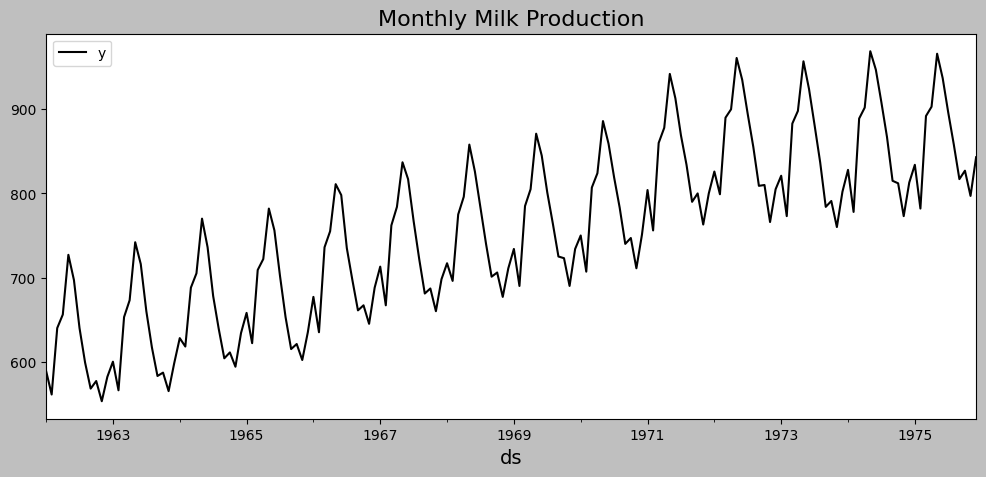

In [21]:
milk.set_index('ds').plot(title='Monthly Milk Production')

In [22]:
train.tail()

ds    y
151 1974-08-01  867
152 1974-09-01  815
153 1974-10-01  812
154 1974-11-01  773
155 1974-12-01  813

In [25]:
?Prophet

Init signature:
Prophet(
    growth='linear',
    changepoints=None,
    n_changepoints=25,
    changepoint_range=0.8,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    holidays=None,
    seasonality_mode='additive',
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale=0.05,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None,
    scaling: str = 'absmax',
    holidays_mode=None,
)
Docstring:     
Prophet forecaster.

Parameters
----------
growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
    flat trend.
changepoints: List of dates at which to include potential changepoints. If
    not specified, potential changepoints are selected automatically.
n_changepoints: Number of potential changepoints to include. Not used
    if input `changepoints` is supplied. If `changepoints` is not supplied,
    then n_changepoints potential changep

In [27]:
model = Prophet(seasonality_mode='additive', 
                interval_width=0.80).fit(train)

16:11:01 - cmdstanpy - INFO - Chain [1] start processing
16:11:01 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
model.seasonalities

OrderedDict([('yearly',
              {'period': 365.25,
               'fourier_order': 10,
               'prior_scale': 10.0,
               'mode': 'additive',
               'condition_name': None})])

In [31]:
model.uncertainty_samples

1000

In [33]:
model.component_modes

{'additive': ['yearly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [35]:
future = model.make_future_dataframe(len(test), freq='MS')

In [37]:
future

ds
0   1962-01-01
1   1962-02-01
2   1962-03-01
3   1962-04-01
4   1962-05-01
..         ...
163 1975-08-01
164 1975-09-01
165 1975-10-01
166 1975-11-01
167 1975-12-01

[168 rows x 1 columns]

In [39]:
len(milk) == len(future)

True

In [41]:
future.shape

(168, 1)

In [43]:
print(future.tail(12))

            ds
156 1975-01-01
157 1975-02-01
158 1975-03-01
159 1975-04-01
160 1975-05-01
161 1975-06-01
162 1975-07-01
163 1975-08-01
164 1975-09-01
165 1975-10-01
166 1975-11-01
167 1975-12-01


In [45]:
forecast = model.predict(future)

In [47]:
forecast.columns.tolist()

['ds',
 'trend',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 'additive_terms',
 'additive_terms_lower',
 'additive_terms_upper',
 'yearly',
 'yearly_lower',
 'yearly_upper',
 'multiplicative_terms',
 'multiplicative_terms_lower',
 'multiplicative_terms_upper',
 'yhat']

In [49]:
forecast.tail(5)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
163 1975-08-01  862.232732  841.033555  860.109532   860.172616   864.516383   
164 1975-09-01  862.532776  797.759829  818.128542   860.114589   865.181793   
165 1975-10-01  862.823140  800.769404  822.108620   859.795357   866.044551   
166 1975-11-01  863.123184  768.143543  789.651385   859.536306   866.821896   
167 1975-12-01  863.413549  802.540699  825.260660   859.223139   867.609478   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
163      -11.856198            -11.856198            -11.856198 -11.856198   
164      -54.582798            -54.582798            -54.582798 -54.582798   
165      -51.433791            -51.433791            -51.433791 -51.433791   
166      -83.708189            -83.708189            -83.708189 -83.708189   
167      -49.475051            -49.475051            -49.475051 -49.475051   

     yearly_lower  yearly_upper  multiplicative_terms  \
163    -11.856198    -11.856198                   0.0   
164    -54.582798    -54.582798                   0.0   
165    -51.433791    -51.433791                   0.0   
166    -83.708189    -83.708189                   0.0   
167    -49.475051    -49.475051                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
163                         0.0                         0.0  850.376534  
164                         0.0                         0.0  807.949978  
165                         0.0                         0.0  811.389349  
166                         0.0                         0.0  779.414995  
167                         0.0                         0.0  813.938497

In [51]:
cols = ['ds', 'yhat', 'yhat_lower', 'yhat_upper']

In [53]:
forecast[cols].head()

ds        yhat  yhat_lower  yhat_upper
0 1962-01-01  586.777369  577.362461  596.351141
1 1962-02-01  547.348255  537.465567  556.794837
2 1962-03-01  641.420738  631.751984  651.636794
3 1962-04-01  659.039593  648.832658  668.156107
4 1962-05-01  721.884957  712.265890  731.155115

In [55]:
pd.concat([forecast['yhat'].iloc[0:5], train['y'].iloc[0:5]], axis=1)

yhat    y
0  586.777369  589
1  547.348255  561
2  641.420738  640
3  659.039593  656
4  721.884957  727

In [57]:
pd.concat([forecast['yhat'].iloc[-5:], test['y'].iloc[-5:]], axis=1)

yhat    y
163  850.376534  858
164  807.949978  817
165  811.389349  827
166  779.414995  797
167  813.938497  843

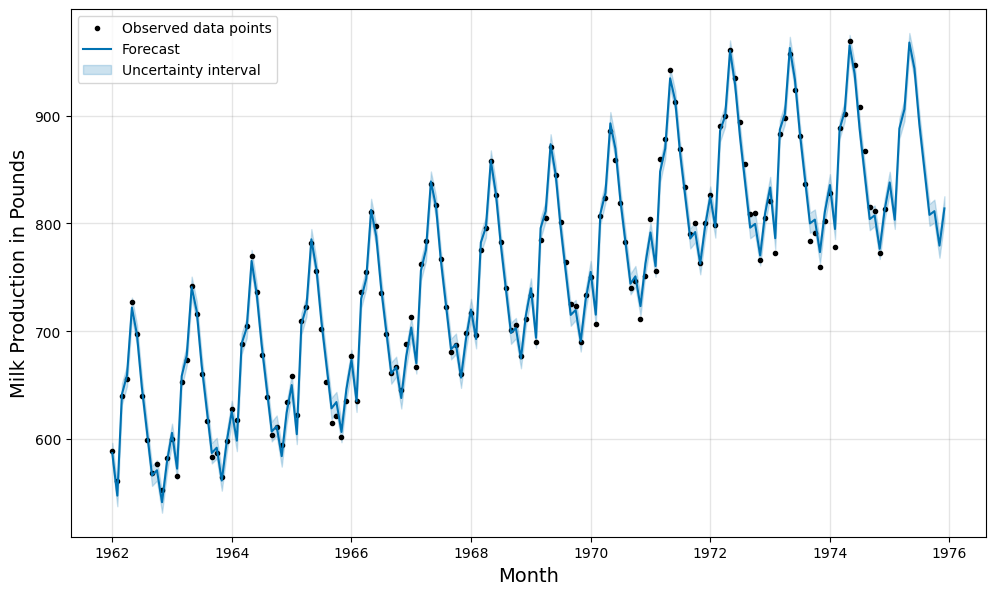

In [59]:
model.plot(forecast, 
           ylabel='Milk Production in Pounds',
           xlabel='Month',
           include_legend=True);

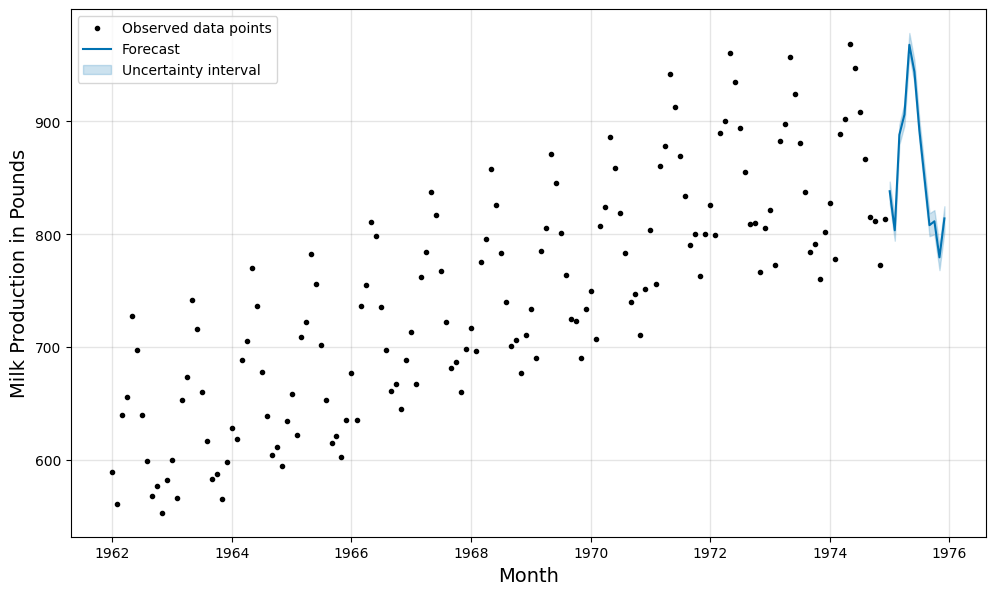

In [61]:
model.plot(model.predict(test),
           ylabel='Milk Production in Pounds',
           xlabel='Month',
          include_legend=True);

In [63]:
model_95 = model = Prophet(seasonality_mode='additive', 
                interval_width=0.95).fit(train)
forecast_95 = model_95.predict(future)
forecast_95[cols].head()

16:11:05 - cmdstanpy - INFO - Chain [1] start processing
16:11:05 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper
0 1962-01-01  586.777369  572.105011  601.889451
1 1962-02-01  547.348255  533.232875  562.134192
2 1962-03-01  641.420738  625.682837  656.156143
3 1962-04-01  659.039593  643.858177  673.916143
4 1962-05-01  721.884957  706.485116  735.815804

In [65]:
forecast[cols].head()

ds        yhat  yhat_lower  yhat_upper
0 1962-01-01  586.777369  577.362461  596.351141
1 1962-02-01  547.348255  537.465567  556.794837
2 1962-03-01  641.420738  631.751984  651.636794
3 1962-04-01  659.039593  648.832658  668.156107
4 1962-05-01  721.884957  712.265890  731.155115

In [67]:
forecast_95[cols].tail()

ds        yhat  yhat_lower  yhat_upper
163 1975-08-01  850.376534  834.445984  865.515339
164 1975-09-01  807.949978  792.419076  823.850468
165 1975-10-01  811.389349  793.863191  827.271358
166 1975-11-01  779.414995  762.289945  797.216900
167 1975-12-01  813.938497  797.984273  831.788818

In [69]:
forecast[cols].tail()

ds        yhat  yhat_lower  yhat_upper
163 1975-08-01  850.376534  841.033555  860.109532
164 1975-09-01  807.949978  797.759829  818.128542
165 1975-10-01  811.389349  800.769404  822.108620
166 1975-11-01  779.414995  768.143543  789.651385
167 1975-12-01  813.938497  802.540699  825.260660

In [71]:
forecast.tail()

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
163 1975-08-01  862.232732  841.033555  860.109532   860.172616   864.516383   
164 1975-09-01  862.532776  797.759829  818.128542   860.114589   865.181793   
165 1975-10-01  862.823140  800.769404  822.108620   859.795357   866.044551   
166 1975-11-01  863.123184  768.143543  789.651385   859.536306   866.821896   
167 1975-12-01  863.413549  802.540699  825.260660   859.223139   867.609478   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
163      -11.856198            -11.856198            -11.856198 -11.856198   
164      -54.582798            -54.582798            -54.582798 -54.582798   
165      -51.433791            -51.433791            -51.433791 -51.433791   
166      -83.708189            -83.708189            -83.708189 -83.708189   
167      -49.475051            -49.475051            -49.475051 -49.475051   

     yearly_lower  yearly_upper  multiplicative_terms  \
163    -11.856198    -11.856198                   0.0   
164    -54.582798    -54.582798                   0.0   
165    -51.433791    -51.433791                   0.0   
166    -83.708189    -83.708189                   0.0   
167    -49.475051    -49.475051                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper        yhat  
163                         0.0                         0.0  850.376534  
164                         0.0                         0.0  807.949978  
165                         0.0                         0.0  811.389349  
166                         0.0                         0.0  779.414995  
167                         0.0                         0.0  813.938497

<Axes: >

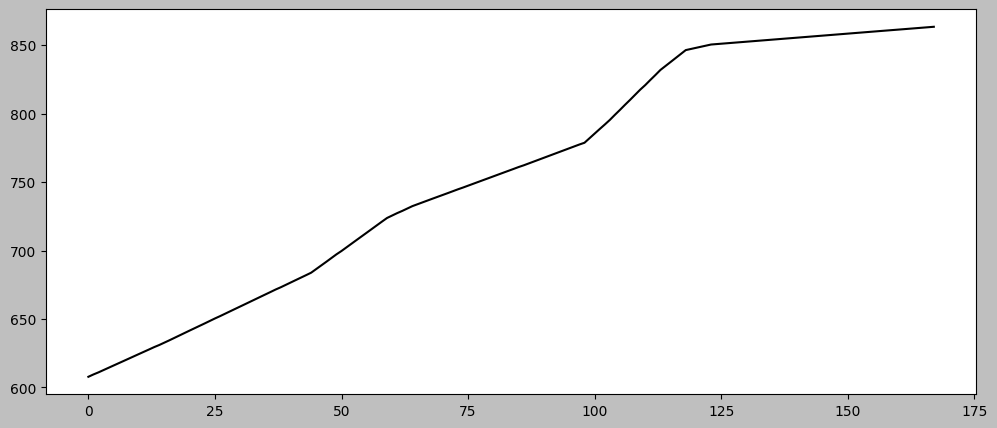

In [73]:
forecast['trend'].plot()

<Axes: >

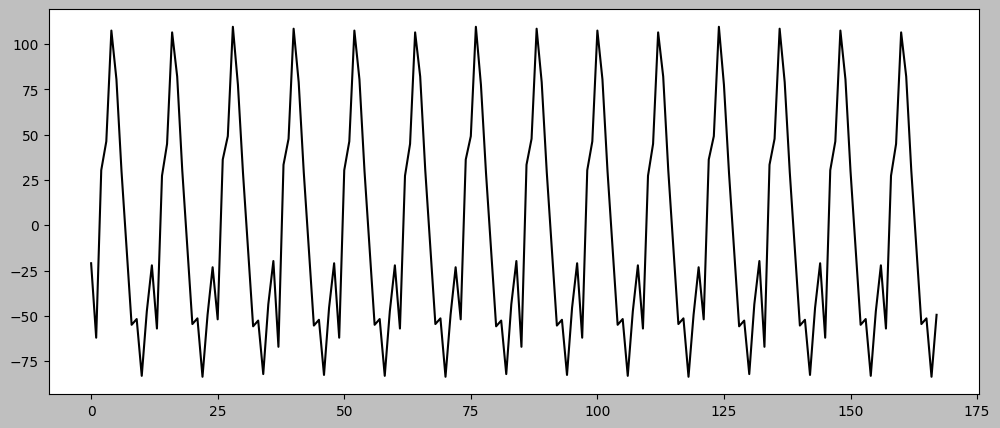

In [75]:
forecast.yearly.plot()

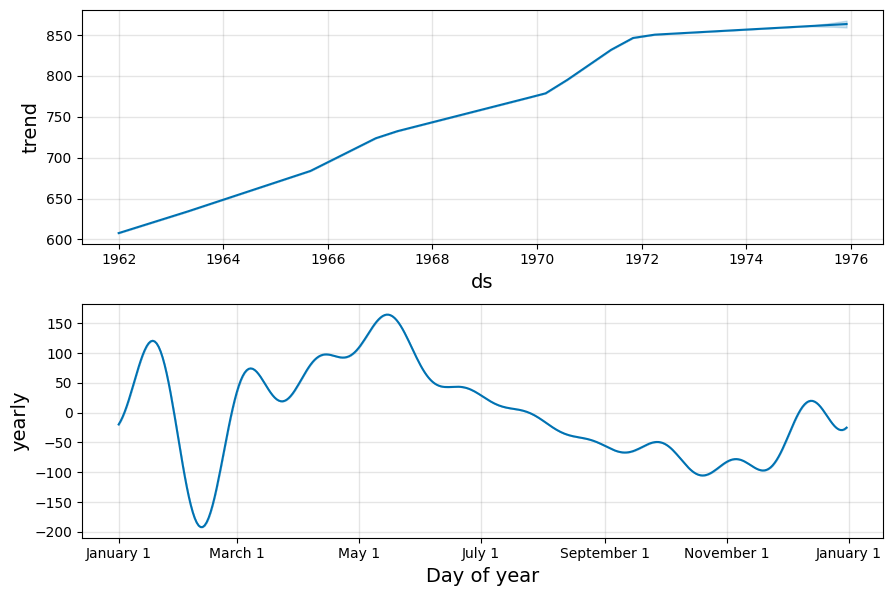

In [77]:
model.plot_components(forecast);

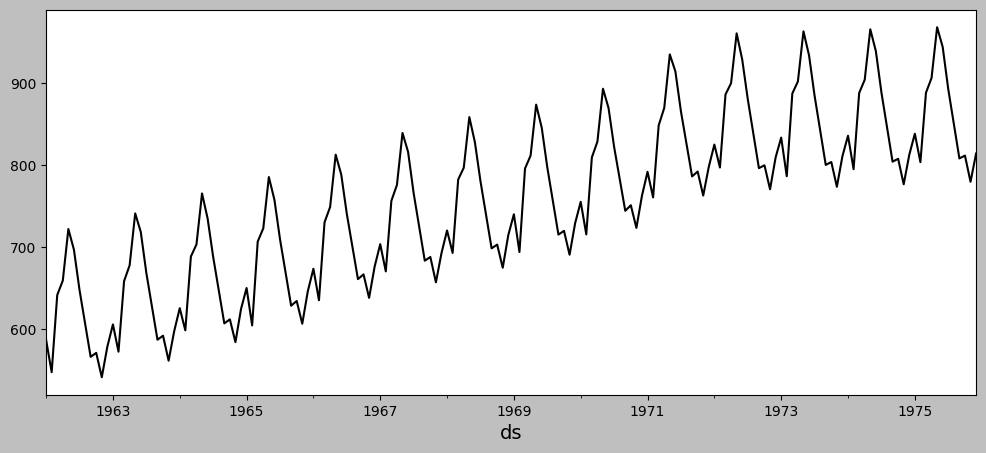

In [79]:
forecast_tmp = forecast.set_index('ds')
(forecast_tmp['trend']+forecast_tmp['yearly']).plot();

In [81]:
sum((forecast['trend']*forecast['yearly']) == forecast['yhat'])

0

In [83]:
(forecast['trend']+forecast['yearly']).head()

0    586.777369
1    547.348255
2    641.420738
3    659.039593
4    721.884957
dtype: float64

In [85]:
forecast['yhat'].head()

0    586.777369
1    547.348255
2    641.420738
3    659.039593
4    721.884957
Name: yhat, dtype: float64

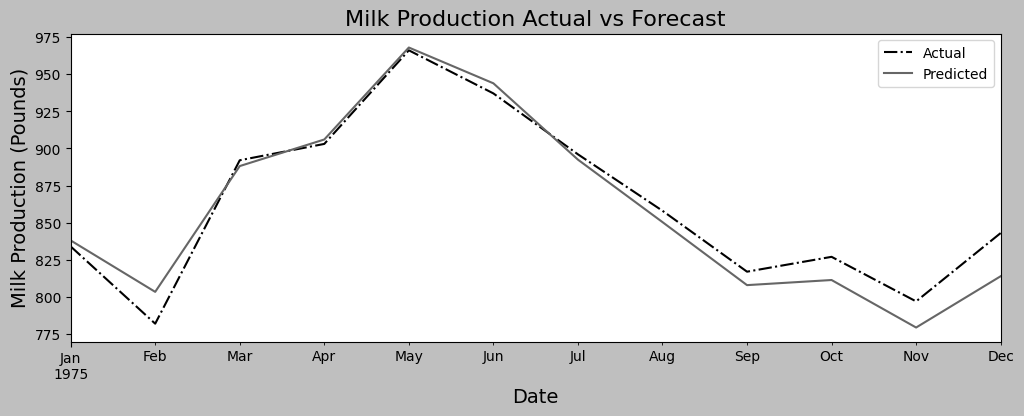

In [87]:
n = len(test)
ax = test.plot(x='ds', y='y',
               label='Actual',
               style='-.',
               figsize=(12,4), xlabel='Date')

forecast.tail(n).plot(x='ds', y='yhat',
              label='Predicted',
              ax=ax,
              title='Milk Production Actual vs Forecast', 
              xlabel='Date', 
              ylabel='Milk Production (Pounds)');

## How it works


In [90]:
from prophet.plot import plot_yearly

model_y4 = Prophet(seasonality_mode='additive', 
                  interval_width=0.80,
                  yearly_seasonality=4).fit(train)
forecast_y4 = model_y4.predict(future)


16:11:10 - cmdstanpy - INFO - Chain [1] start processing
16:11:10 - cmdstanpy - INFO - Chain [1] done processing


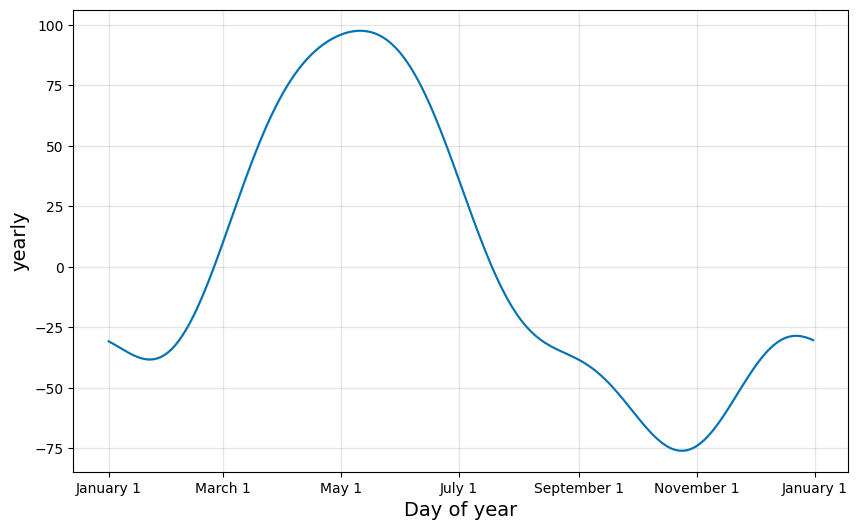

In [92]:
# updated model
plot_yearly(model_y4);

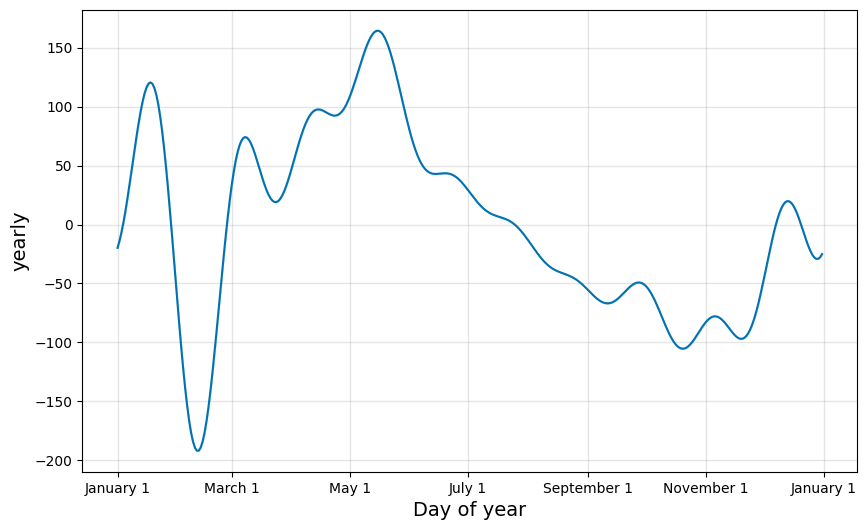

In [94]:
# original model
plot_yearly(model);

In [96]:
model.changepoints.shape

(25,)

In [98]:
model.changepoints.head()

5    1962-06-01
10   1962-11-01
15   1963-04-01
20   1963-09-01
25   1964-02-01
Name: ds, dtype: datetime64[ns]

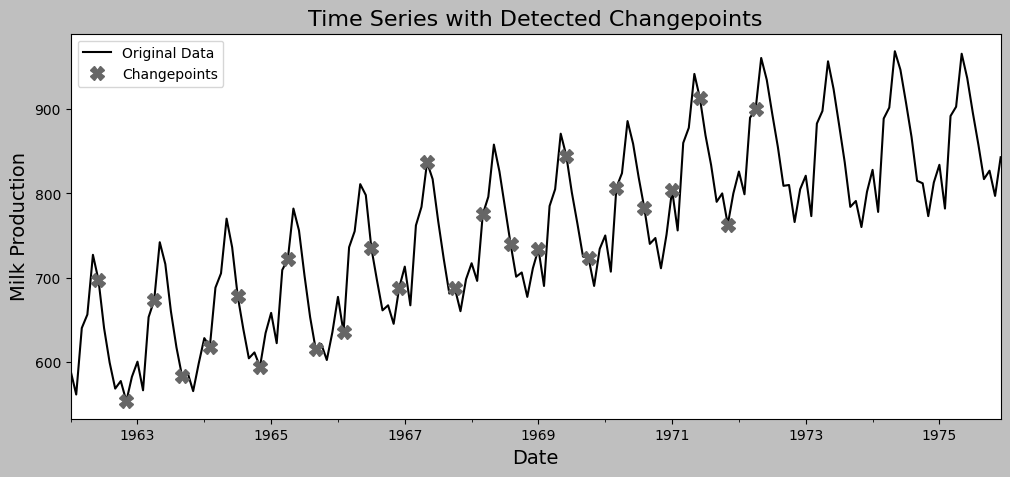

In [100]:
ax = milk.set_index('ds').plot(figsize=(12,5))
milk.set_index('ds').loc[model.changepoints].plot(
    style='X', 
    ax=ax,
    markersize=10  
)
plt.xlabel('Date')
plt.ylabel('Milk Production')
plt.title('Time Series with Detected Changepoints')
plt.legend(['Original Data', 'Changepoints']);

In [102]:
model_no_uncertainty = Prophet(uncertainty_samples=False).fit(train)
forecast_no_uncertainty  = model_no_uncertainty.predict(future)
forecast_no_uncertainty.columns.tolist()

16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing


['ds', 'trend', 'additive_terms', 'yearly', 'multiplicative_terms', 'yhat']

## There is more

### Changepoint Detection

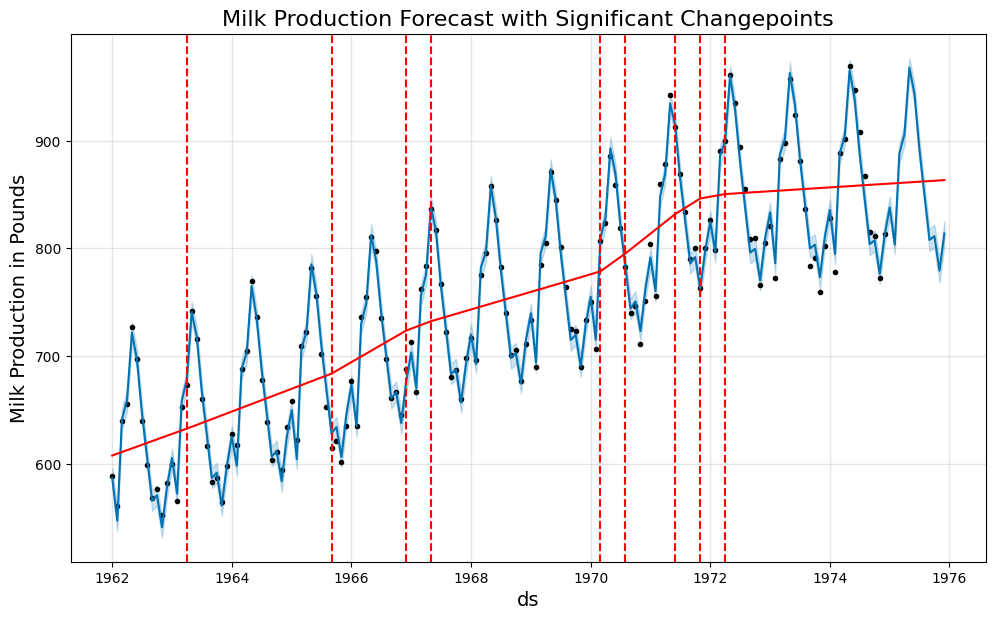

In [106]:
from prophet.plot import add_changepoints_to_plot

# Create base plot with forecast
fig = model.plot(forecast, ylabel='Milk Production in Pounds')
# Add changepoint visualization
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.title('Milk Production Forecast with Significant Changepoints');

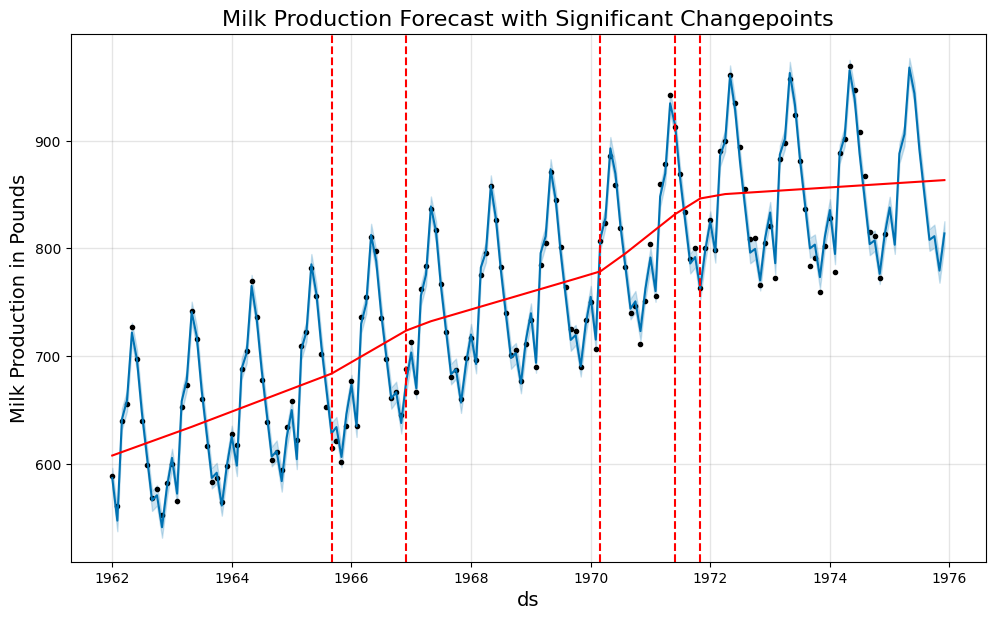

In [108]:
from prophet.plot import add_changepoints_to_plot

# Create base plot with forecast
fig = model.plot(forecast, ylabel='Milk Production in Pounds')
# Add changepoint visualization
add_changepoints_to_plot(fig.gca(), model, forecast, threshold=0.1)
plt.title('Milk Production Forecast with Significant Changepoints');

In [110]:
model.params.keys()

odict_keys(['lp__', 'k', 'm', 'delta', 'sigma_obs', 'beta', 'trend'])

In [112]:
print(model.params['delta'])

[[ 4.45860e-09 -6.20724e-09  1.49544e-02  4.04784e-05  5.86443e-09
   1.89663e-10 -9.72030e-09  3.44925e-08  1.45392e-01  1.49468e-10
  -2.43211e-08 -1.48081e-01 -6.21233e-02 -1.27773e-08 -1.09484e-09
   9.59719e-11  6.09539e-04  2.68757e-03  1.21536e-03  3.08689e-01
   5.50464e-02 -2.76747e-08 -1.23803e-01 -3.30631e-01 -8.33208e-02]]


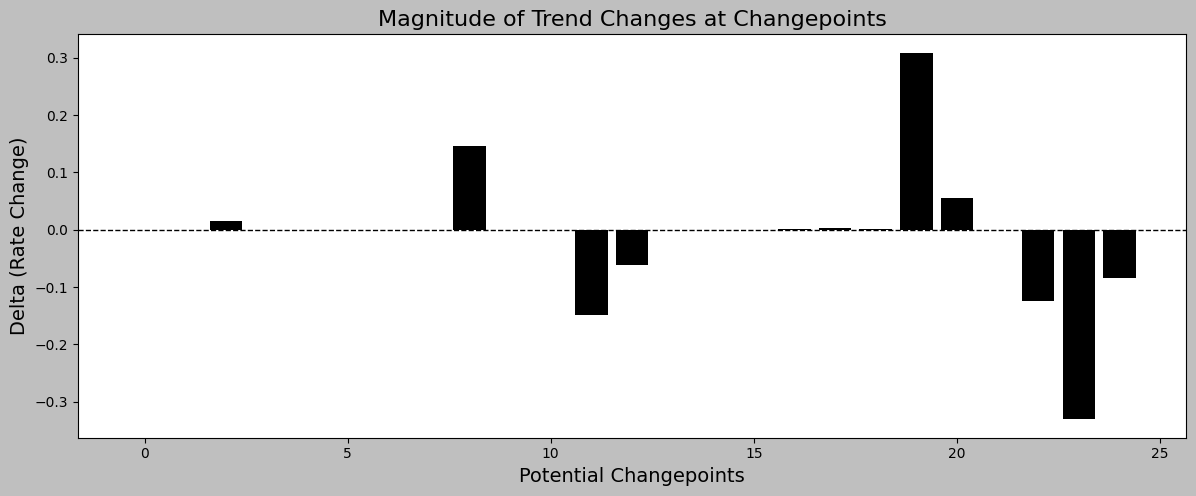

In [114]:
# Extract delta values
deltas = model.params['delta'].ravel()
indices = list(range(len(deltas)))

# Plot bar chart
plt.bar(indices, deltas)
plt.axhline(0, color='black', linewidth=1, linestyle='--')  
plt.title('Magnitude of Trend Changes at Changepoints')
plt.xlabel('Potential Changepoints')
plt.ylabel('Delta (Rate Change)')
plt.tight_layout();


### Cross Validation

In [131]:
len(milk) 

168

In [133]:
milk.head(1)

ds    y
0 1962-01-01  589

In [135]:
milk.tail(1)

ds    y
167 1975-12-01  843

In [189]:
from prophet.diagnostics import cross_validation, performance_metrics
    
# Cross-validation over the last 12 months
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon='365 days')

# View the cross-validation results
df_cv.head()


16:59:38 - cmdstanpy - INFO - Chain [1] start processing                                                                                                                                                               | 0/19 [00:00<?, ?it/s]
16:59:48 - cmdstanpy - INFO - Chain [1] done processing
16:59:48 - cmdstanpy - INFO - Chain [1] start processing                                                                                                                                                       | 1/19 [00:10<03:01, 10.11s/it]
16:59:48 - cmdstanpy - INFO - Chain [1] done processing
16:59:48 - cmdstanpy - INFO - Chain [1] start processing                                                                                                                                                       | 2/19 [00:10<01:12,  4.26s/it]
16:59:48 - cmdstanpy - INFO - Chain [1] done processing
16:59:48 - cmdstanpy - INFO - Chain [1] start processing                                                           

ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1965-02-01  625.892938  621.523363  630.663773  622 1965-01-17
1 1965-03-01  710.385078  696.710482  725.050533  709 1965-01-17
2 1965-04-01  727.222480  702.377261  752.380902  722 1965-01-17
3 1965-05-01  795.152898  756.630939  832.962859  782 1965-01-17
4 1965-06-01  763.399318  710.172130  813.119081  756 1965-01-17

In [235]:
print(df_cv.head())

          ds        yhat  yhat_lower  yhat_upper    y     cutoff
0 1965-02-01  625.892938  621.523363  630.663773  622 1965-01-17
1 1965-03-01  710.385078  696.710482  725.050533  709 1965-01-17
2 1965-04-01  727.222480  702.377261  752.380902  722 1965-01-17
3 1965-05-01  795.152898  756.630939  832.962859  782 1965-01-17
4 1965-06-01  763.399318  710.172130  813.119081  756 1965-01-17


In [233]:
df_perf = performance_metrics(df_cv)
print(df_perf.iloc[: , :-1].head())

  horizon         mse       rmse        mae      mape     mdape     smape
0 37 days  242.972743  15.587583  12.148291  0.015787  0.013839  0.015745
1 41 days  244.548865  15.638058  12.205994  0.015949  0.013839  0.015892
2 42 days  251.287816  15.852060  12.427641  0.016183  0.013839  0.016144
3 43 days  243.250786  15.596499  11.882913  0.015513  0.011751  0.015468
4 46 days  246.641600  15.704827  12.063200  0.015748  0.013839  0.015710


In [205]:
df_cv.shape

(228, 6)

In [207]:
performance_metrics(df_cv).shape

(176, 8)

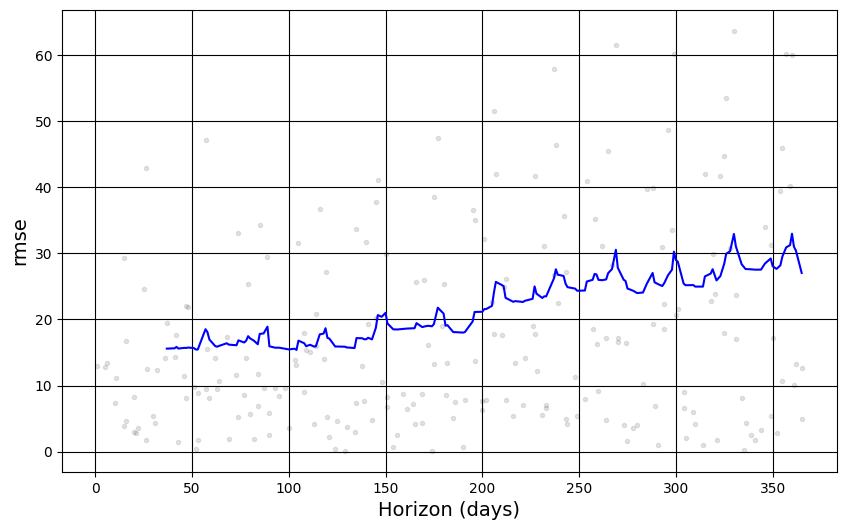

In [292]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(df_cv, 
                             metric='rmse', 
                             rolling_window=0.1, 
                             point_color='black');

### Adding Holidays and Regressors

In [40]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

In [118]:
retail = Path('../../datasets/Ch11/weekly_sales.csv')
retail_df = pd.read_csv(retail, parse_dates=['Date'])
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   Weekly_Sales  143 non-null    float64       
 2   Holiday_Flag  143 non-null    float64       
 3   Temperature   143 non-null    float64       
 4   Fuel_Price    143 non-null    float64       
 5   CPI           143 non-null    float64       
 6   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 7.9 KB


In [142]:
retail_df.rename(columns={'Date': 'ds', 
                          'Weekly_Sales':'y'}, 
                 inplace=True)
retail_df.head()

ds           y  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0 2010-02-05  1105572.01           0.0        34.04      2.7178  167.730885   
1 2010-02-12  1074148.39           1.0        34.15      2.6940  167.825608   
2 2010-02-19  1072822.08           0.0        37.72      2.6721  167.871686   
3 2010-02-26   977079.36           0.0        39.24      2.6839  167.909657   
4 2010-03-05  1041588.23           0.0        42.92      2.7312  167.947628   

   Unemployment  
0         8.619  
1         8.619  
2         8.619  
3         8.619  
4         8.619

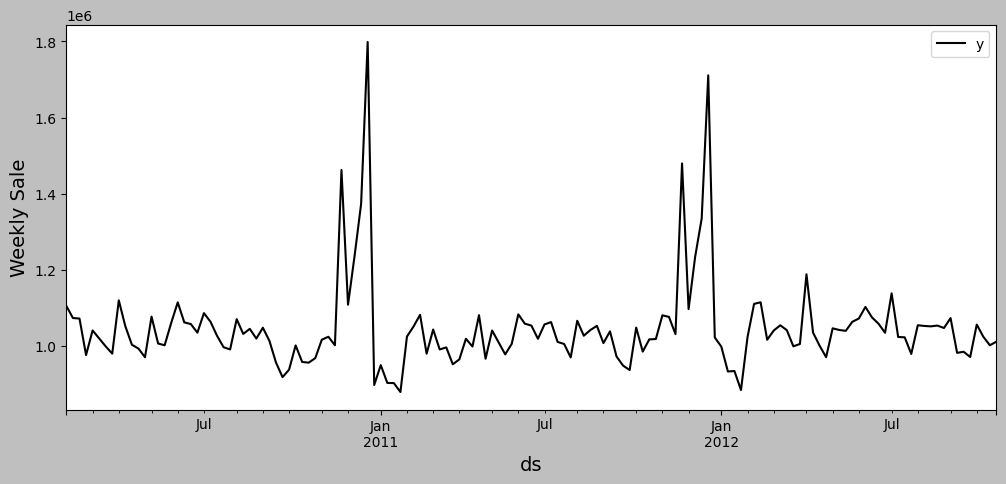

In [194]:
retail_df.plot(x='ds', 
               y='y',
              ylabel='Weekly Sale');

In [148]:
test_split = 12
retail_train, retail_test = split_data(retail_df, test_split)

train: 131 , test: 12


In [150]:
retail_train.columns

Index(['ds', 'y', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment'],
      dtype='object')

In [152]:
retail_df

ds           y  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0   2010-02-05  1105572.01           0.0        34.04      2.7178  167.730885   
1   2010-02-12  1074148.39           1.0        34.15      2.6940  167.825608   
2   2010-02-19  1072822.08           0.0        37.72      2.6721  167.871686   
3   2010-02-26   977079.36           0.0        39.24      2.6839  167.909657   
4   2010-03-05  1041588.23           0.0        42.92      2.7312  167.947628   
..         ...         ...           ...          ...         ...         ...   
138 2012-09-28   971886.65           0.0        68.75      3.8546  176.373588   
139 2012-10-05  1057036.43           0.0        65.97      3.8452  176.505052   
140 2012-10-12  1025078.09           0.0        58.34      3.8967  176.636515   
141 2012-10-19  1002720.23           0.0        60.71      3.8800  176.652613   
142 2012-10-26  1012091.47           0.0        61.05      3.7915  176.649482   

     Unemployment  
0           8.619  
1           8.619  
2           8.619  
3           8.619  
4           8.619  
..            ...  
138         7.237  
139         6.954  
140         6.954  
141         6.954  
142         6.954  

[143 rows x 7 columns]

In [24]:
#pd.concat([holidays[['holiday', 'ds']], us_holidays])

In [154]:
model_retail_v1 = Prophet(seasonality_mode='additive').fit(retail_train)
retail_future = model_retail_v1.make_future_dataframe(len(retail_test), freq='W-FRI')
retail_forecast_v1 = model_retail_v1.predict(retail_future)

13:45:19 - cmdstanpy - INFO - Chain [1] start processing
13:45:19 - cmdstanpy - INFO - Chain [1] done processing


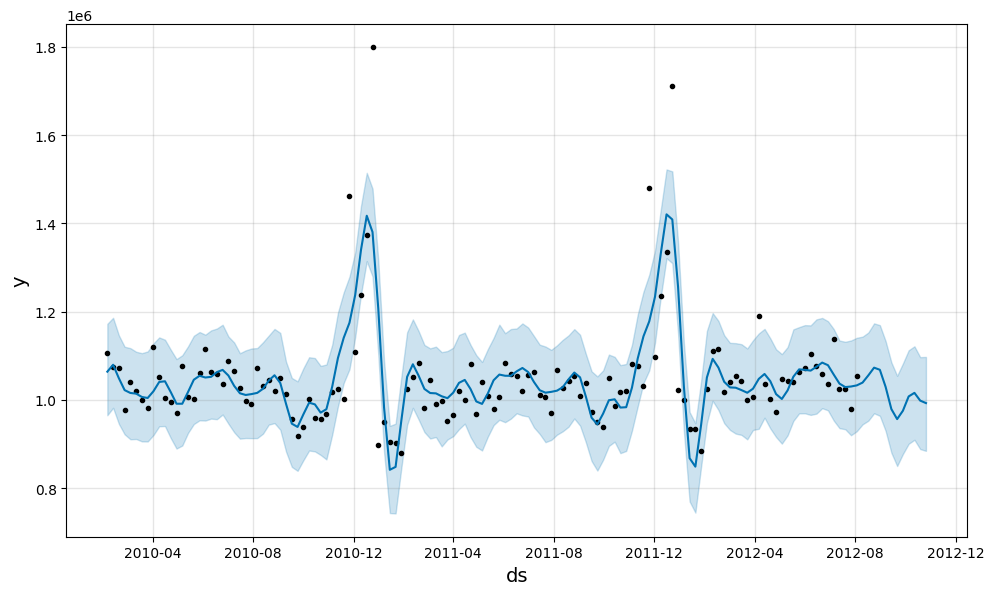

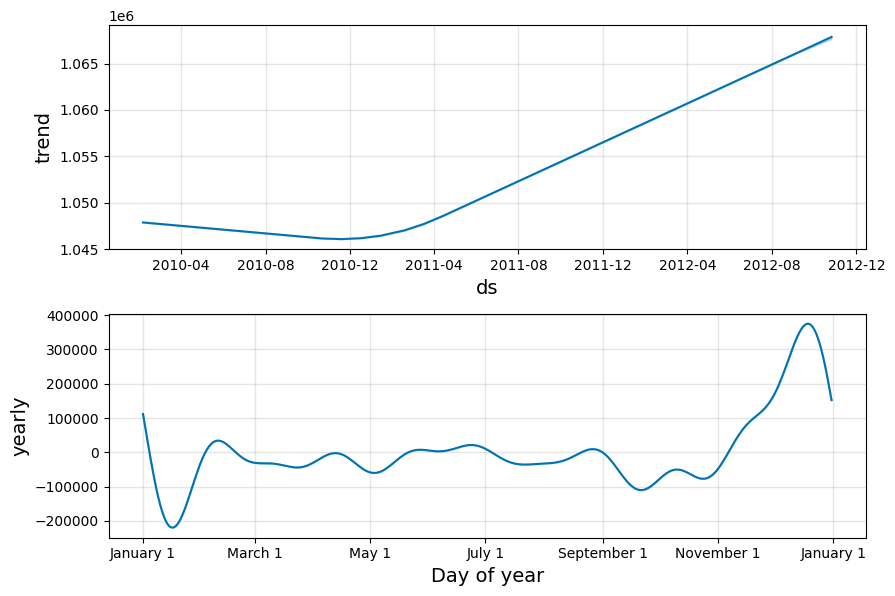

In [156]:
model_retail_v1.plot(retail_forecast_v1);
model_retail_v1.plot_components(retail_forecast_v1);

In [158]:
from prophet.diagnostics import cross_validation, performance_metrics
    
# Cross-validation over the last 12 months
retail_cv_v1 = cross_validation(model_retail_v1, 
                                initial='730 days', 
                                period='30 days', 
                                horizon='12 days')

retail_perf_v1 = performance_metrics(retail_cv_v1)
print(retail_perf_v1[['mae', 'rmse', 'mape']].head())

13:45:23 - cmdstanpy - INFO - Chain [1] start processing                                                                                                                                                                | 0/6 [00:00<?, ?it/s]
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing████████████████▋                                                                                                                                       | 2/6 [00:00<00:00, 19.62it/s]
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing
13:45:23 - cmdstanpy - INFO - Chain [1] done processing
13:45:23 - cmdstanpy - INFO - Chain [1] start processing███████████████

            mae          rmse      mape
0  12137.921197  12137.921197  0.011933
1    862.073739    862.073739  0.000810
2  38634.029316  38634.029316  0.039768
3  56460.683734  56460.683734  0.057617
4   3367.179546   3367.179546  0.003347


In [174]:
from prophet.make_holidays import make_holidays_df

holidays = pd.DataFrame({
    'holiday': 'custom holiday',  # Name of the holiday
    'ds': retail_train[retail_train['Holiday_Flag'] == 1]['ds'],  
})

years = retail_df['ds'].dt.year.unique().tolist()
us_holidays = make_holidays_df(year_list=years,
                            country='US')

holidays = pd.concat([holidays, us_holidays])
holidays

holiday         ds
1                 custom holiday 2010-02-12
31                custom holiday 2010-09-10
42                custom holiday 2010-11-26
47                custom holiday 2010-12-31
53                custom holiday 2011-02-11
83                custom holiday 2011-09-09
94                custom holiday 2011-11-25
99                custom holiday 2011-12-30
105               custom holiday 2012-02-10
0                 New Year's Day 2010-01-01
1      New Year's Day (observed) 2010-12-31
2                   Memorial Day 2010-05-31
3               Independence Day 2010-07-04
4    Independence Day (observed) 2010-07-05
5                      Labor Day 2010-09-06
6                   Veterans Day 2010-11-11
7                   Thanksgiving 2010-11-25
8                  Christmas Day 2010-12-25
9       Christmas Day (observed) 2010-12-24
10    Martin Luther King Jr. Day 2010-01-18
11         Washington's Birthday 2010-02-15
12                  Columbus Day 2010-10-11
13                New Year's Day 2011-01-01
14                  Memorial Day 2011-05-30
15              Independence Day 2011-07-04
16                     Labor Day 2011-09-05
17                  Veterans Day 2011-11-11
18                  Thanksgiving 2011-11-24
19                 Christmas Day 2011-12-25
20      Christmas Day (observed) 2011-12-26
21    Martin Luther King Jr. Day 2011-01-17
22         Washington's Birthday 2011-02-21
23                  Columbus Day 2011-10-10
24                New Year's Day 2012-01-01
25     New Year's Day (observed) 2012-01-02
26                  Memorial Day 2012-05-28
27              Independence Day 2012-07-04
28                     Labor Day 2012-09-03
29                  Veterans Day 2012-11-11
30       Veterans Day (observed) 2012-11-12
31                  Thanksgiving 2012-11-22
32                 Christmas Day 2012-12-25
33    Martin Luther King Jr. Day 2012-01-16
34         Washington's Birthday 2012-02-20
35                  Columbus Day 2012-10-08

In [198]:
model_retail_v2 = Prophet(seasonality_mode='additive', holidays=holidays)
model_retail_v2.add_regressor('Temperature')
model_retail_v2.add_regressor('Fuel_Price')
model_retail_v2.add_regressor('CPI')
model_retail_v2.add_regressor('Unemployment')

model_retail_v2.fit(retail_train)

18:18:46 - cmdstanpy - INFO - Chain [1] start processing
18:18:46 - cmdstanpy - INFO - Chain [1] done processing


In [202]:
retail_future_v2 = retail_future.merge(retail_df[['ds',
                                                  'Temperature', 
                                                  'Fuel_Price',
                                                  'CPI', 
                                                  'Unemployment']], 
                                       on='ds', how='left')
retail_future_v2.tail(12)

ds  Temperature  Fuel_Price         CPI  Unemployment
131 2012-08-10        81.58      3.6329  175.689620         7.237
132 2012-08-17        79.43      3.7205  175.743527         7.237
133 2012-08-24        74.59      3.7596  175.833841         7.237
134 2012-08-31        77.79      3.7691  175.924154         7.237
135 2012-09-07        78.04      3.8426  176.014468         7.237
136 2012-09-14        70.24      3.8520  176.110660         7.237
137 2012-09-21        67.92      3.9079  176.242124         7.237
138 2012-09-28        68.75      3.8546  176.373588         7.237
139 2012-10-05        65.97      3.8452  176.505052         6.954
140 2012-10-12        58.34      3.8967  176.636515         6.954
141 2012-10-19        60.71      3.8800  176.652613         6.954
142 2012-10-26        61.05      3.7915  176.649482         6.954

In [204]:
retail_forecast_v2 = model_retail_v2.predict(retail_future_v2)

In [206]:
retail_forecast_v2.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'CPI', 'CPI_lower', 'CPI_upper', 'Christmas Day', 'Christmas Day_lower',
       'Christmas Day_upper', 'Christmas Day (observed)',
       'Christmas Day (observed)_lower', 'Christmas Day (observed)_upper',
       'Columbus Day', 'Columbus Day_lower', 'Columbus Day_upper',
       'Fuel_Price', 'Fuel_Price_lower', 'Fuel_Price_upper',
       'Independence Day', 'Independence Day_lower', 'Independence Day_upper',
       'Independence Day (observed)', 'Independence Day (observed)_lower',
       'Independence Day (observed)_upper', 'Labor Day', 'Labor Day_lower',
       'Labor Day_upper', 'Martin Luther King Jr. Day',
       'Martin Luther King Jr. Day_lower', 'Martin Luther King Jr. Day_upper',
       'Memorial Day', 'Memorial Day_lower', 'Memorial Day_upper',
       'New Year's Day', 'New Year's Day_lower', 'New Year's Day_upper',
       'New Year's Day (observed)', 'New Year's Day (observed)_lower',
   

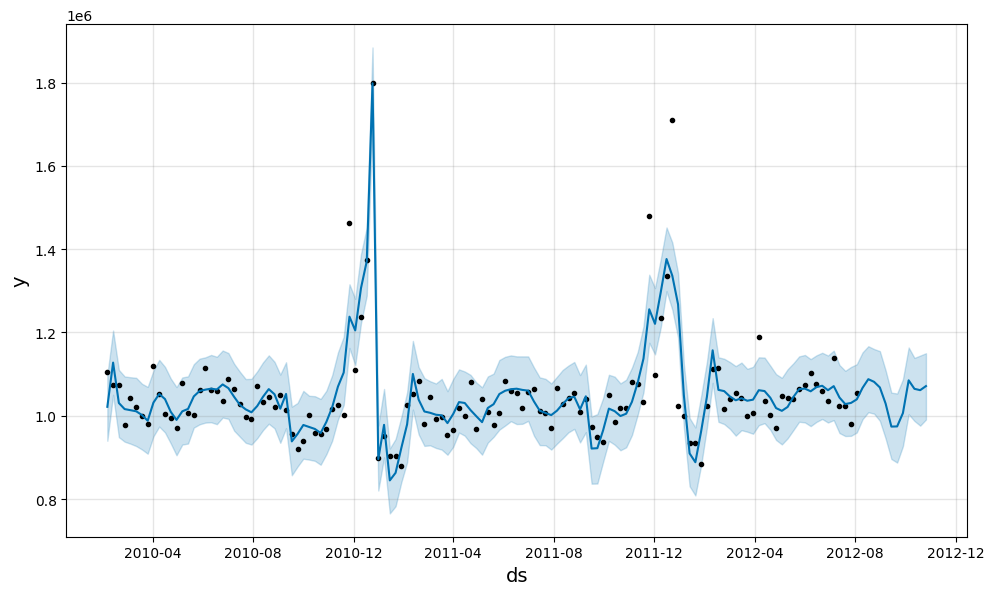

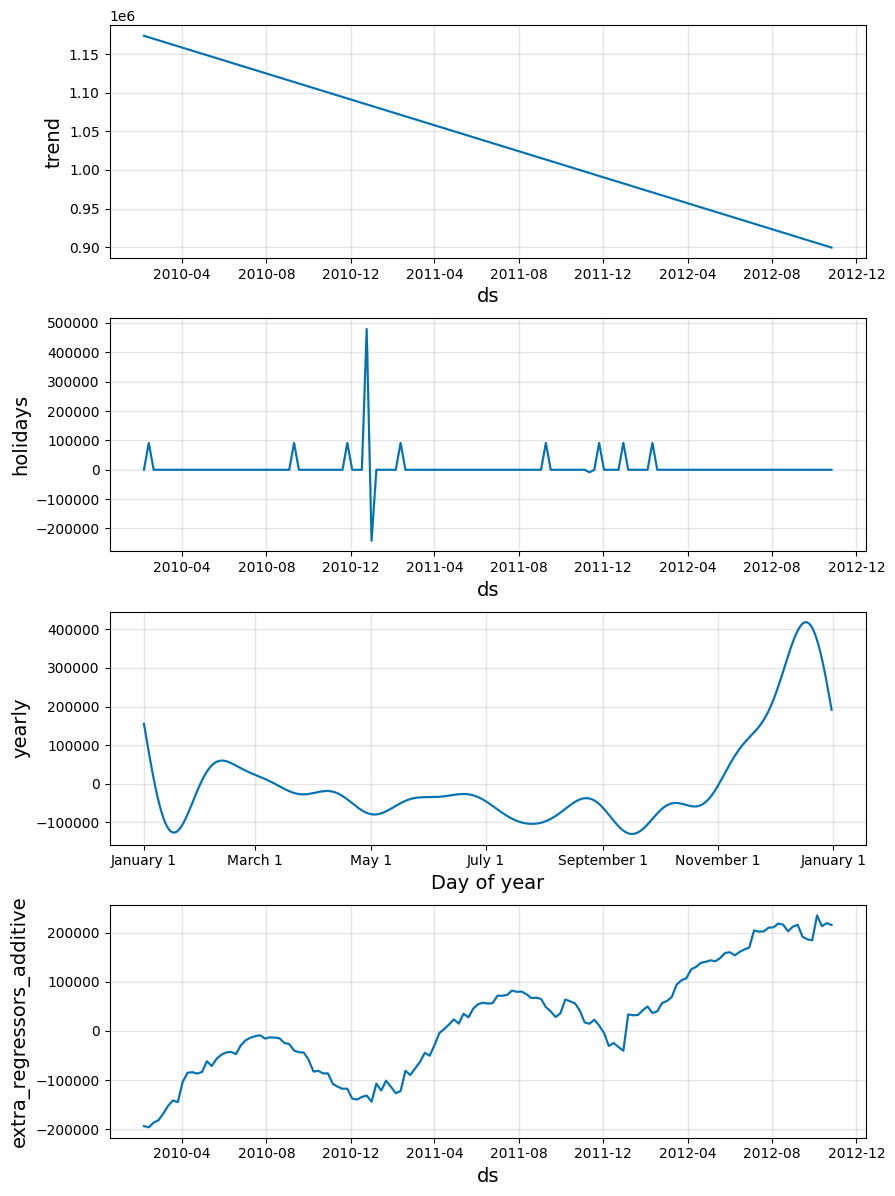

In [208]:
model_retail_v2.plot(retail_forecast_v2);
model_retail_v2.plot_components(retail_forecast_v2);

In [246]:
# Cross-validation over the last 12 months
retail_cv_v2 = cross_validation(model_retail_v2, 
                                initial='730 days', 
                                period='30 days', 
                                horizon='12 days')

# View the cross-validation results
retail_cv_v2.head()

23:05:00 - cmdstanpy - INFO - Chain [1] start processing                                                                                                                                                                | 0/6 [00:00<?, ?it/s]
23:05:00 - cmdstanpy - INFO - Chain [1] done processing
23:05:00 - cmdstanpy - INFO - Chain [1] start processing
23:05:00 - cmdstanpy - INFO - Chain [1] done processing
23:05:00 - cmdstanpy - INFO - Chain [1] start processing████████████████▋                                                                                                                                       | 2/6 [00:00<00:00, 12.65it/s]
23:05:00 - cmdstanpy - INFO - Chain [1] done processing
23:05:00 - cmdstanpy - INFO - Chain [1] start processing
23:05:00 - cmdstanpy - INFO - Chain [1] done processing
23:05:00 - cmdstanpy - INFO - Chain [1] start processing████████████████████████████████████████████████████████████████████████████████████▎                                           

ds          yhat     yhat_lower    yhat_upper           y     cutoff
0 2012-02-24  1.059786e+06  971330.873485  1.143245e+06  1017144.59 2012-02-23
1 2012-03-02  1.045696e+06  952512.888006  1.134008e+06  1041356.33 2012-02-23
2 2012-03-30  1.023550e+06  945438.060779  1.111328e+06  1006063.60 2012-03-24
3 2012-04-27  1.016202e+06  931507.097102  1.096416e+06   971484.42 2012-04-23
4 2012-05-04  1.007417e+06  912916.879519  1.093989e+06  1047204.40 2012-04-23

In [250]:
retail_perf_v2 = performance_metrics(retail_cv_v2)
print(retail_perf_v2[['mae', 'rmse', 'mape']].sort_values(by='rmse'))

            mae          rmse      mape
6   4340.079810   4340.079810  0.004168
1   4695.821434   4695.821434  0.004412
9   6634.457232   6634.457232  0.006287
5  11931.275894  11931.275894  0.011522
7  16750.714847  16750.714847  0.015612
4  17486.544024  17486.544024  0.017381
8  39787.502342  39787.502342  0.037994
0  42641.802149  42641.802149  0.041923
2  44717.975704  44717.975704  0.046031
3  61890.413660  61890.413660  0.063158


In [274]:
retail_perf_v2.mean()[1:-1]

mse      1004511335.583567
rmse           25087.65871
mae            25087.65871
mape              0.024849
mdape             0.024849
smape             0.024532
dtype: object

In [252]:
print(retail_perf_v1[['mae', 'rmse', 'mape']].sort_values(by='rmse'))

            mae          rmse      mape
1    862.073739    862.073739  0.000810
4   3367.179546   3367.179546  0.003347
0  12137.921197  12137.921197  0.011933
7  13089.224346  13089.224346  0.012200
9  19024.481019  19024.481019  0.018029
6  25395.526964  25395.526964  0.024387
5  37680.720840  37680.720840  0.036389
2  38634.029316  38634.029316  0.039768
8  49244.837803  49244.837803  0.047025
3  56460.683734  56460.683734  0.057617


In [272]:
retail_perf_v1.mean()[1:-1]

mse      986288946.425682
rmse          25589.66785
mae           25589.66785
mape              0.02515
mdape             0.02515
smape            0.025007
dtype: object

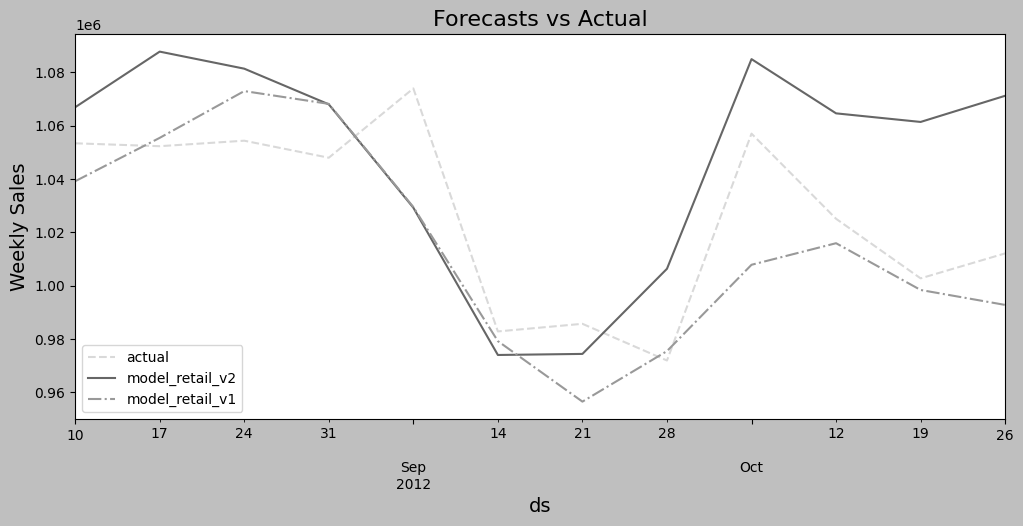

In [232]:
ax = retail_test.plot(x='ds', 
                      y='y', 
                      style='--', 
                      label='actual', 
                      alpha=0.15, 
                      title='Forecasts vs Actual', 
                      ylabel='Weekly Sales')
retail_forecast_v2.tail(12).plot(x='ds', y='yhat', ax=ax, 
                                 label='model_retail_v2', 
                                 style='-')
retail_forecast_v1.tail(12).plot(x='ds', y='yhat', ax=ax,
                                 label='model_retail_v1', 
                                 style='-.');

#  Recipe 2: Time Series Forecasting with Theta 

In [10]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, 
                   parse_dates=['month'], 
                   index_col='month')
milk.head()

production
month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

In [12]:
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

train: 156 , test: 12
Train: (156, 1)
Test: (12, 1)


<Axes: xlabel='month'>

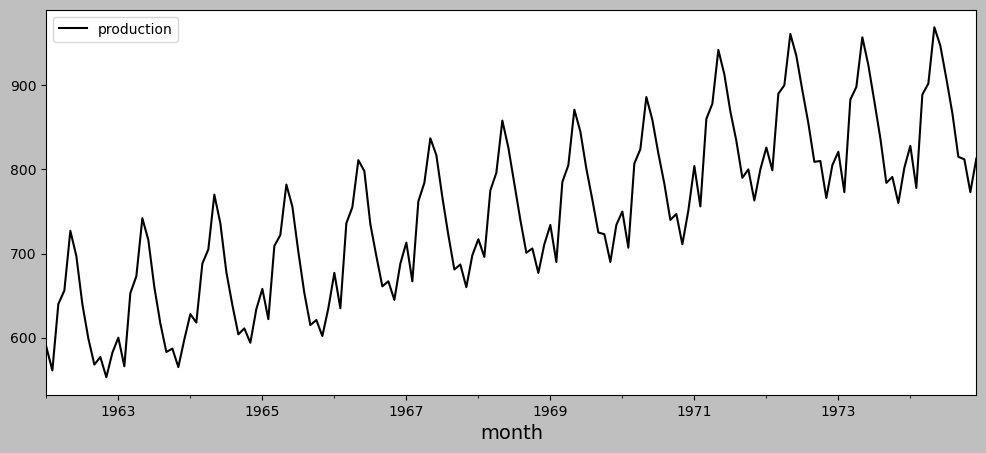

In [14]:
train.plot()

In [16]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [18]:
model = ThetaModel(train,
                  deseasonalize=True)

In [20]:
results = model.fit()

In [22]:
print(results.summary())

                              ThetaModel Results                              
Dep. Variable:             production   No. Observations:                  156
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Mon, 10 Feb 2025   Deseas. Method:         Multiplicative
Time:                        10:05:48   Period:                             12
Sample:                    01-01-1962                                         
                         - 12-01-1974                                         
  Parameter Estimates   
          Parameters    
------------------------
b0    1.8208359090694586
alpha 0.9997934080438782
------------------------


In [24]:
results.params

b0       1.820836
alpha    0.999793
dtype: float64

In [32]:
n = test.shape[0]

forecast = results.forecast(steps=n, theta=2)
forecast_df = pd.Series(forecast.tolist(), index=test.index)
print(forecast_df)

month
1975-01-01    842.763868
1975-02-01    798.584222
1975-03-01    906.159891
1975-04-01    925.102611
1975-05-01    996.154497
1975-06-01    964.758678
1975-07-01    905.989855
1975-08-01    856.248938
1975-09-01    808.418465
1975-10-01    813.948492
1975-11-01    780.025236
1975-12-01    823.296964
dtype: float64


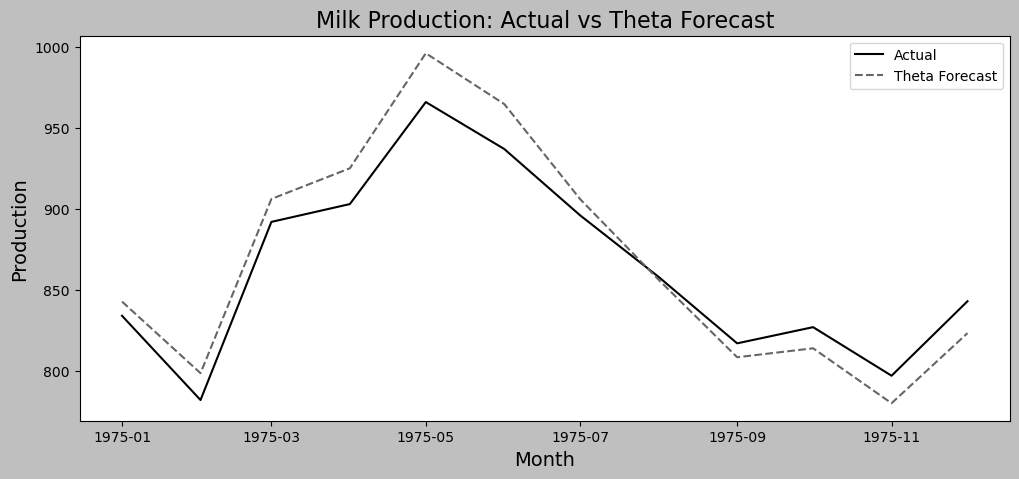

In [54]:
idx = test.index
plt.plot(idx, test['production'], label='Actual')
plt.plot(idx, forecast_df, 
         label='Theta Forecast', 
         linestyle='--')
plt.title('Milk Production: Actual vs Theta Forecast')
plt.xlabel('Month')
plt.ylabel('Production')
plt.legend()
plt.show()

In [58]:
components = results.forecast_components(steps=n)
print(components)

         trend        ses  seasonal
157   1.821212  862.63851  0.975930
158   3.642048  862.63851  0.923796
159   5.462884  862.63851  1.047136
160   7.283720  862.63851  1.067902
161   9.104556  862.63851  1.148714
162  10.925392  862.63851  1.111344
163  12.746228  862.63851  1.042552
164  14.567064  862.63851  0.984282
165  16.387899  862.63851  0.928328
166  18.208735  862.63851  0.933702
167  20.029571  862.63851  0.893855
168  21.850407  862.63851  0.942458


<Axes: title={'center': 'Trend Component'}>

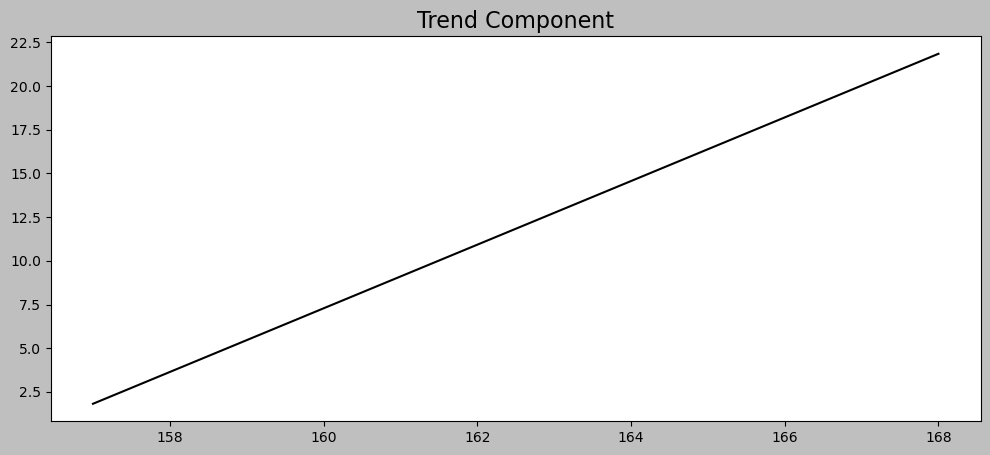

In [70]:
components['trend'].plot(title='Trend Component')

<Axes: title={'center': 'SES component'}>

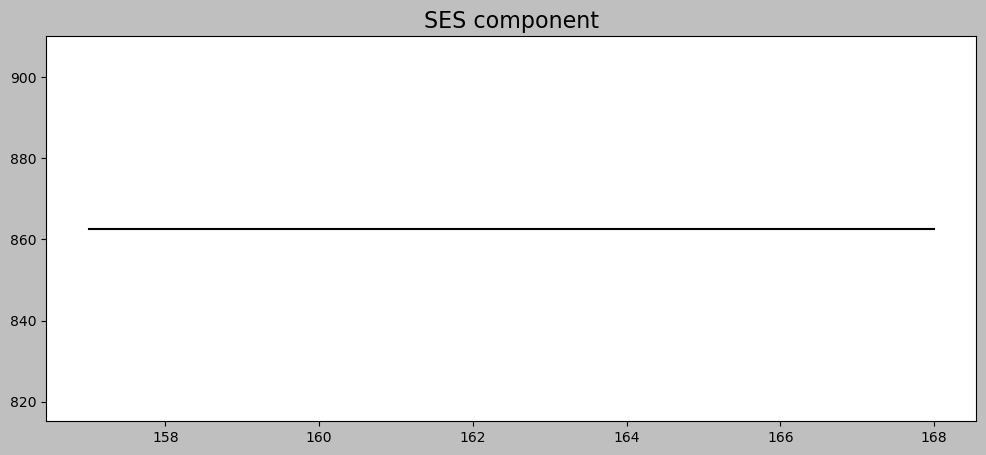

In [68]:
components['ses'].plot(title='SES Component')

<Axes: >

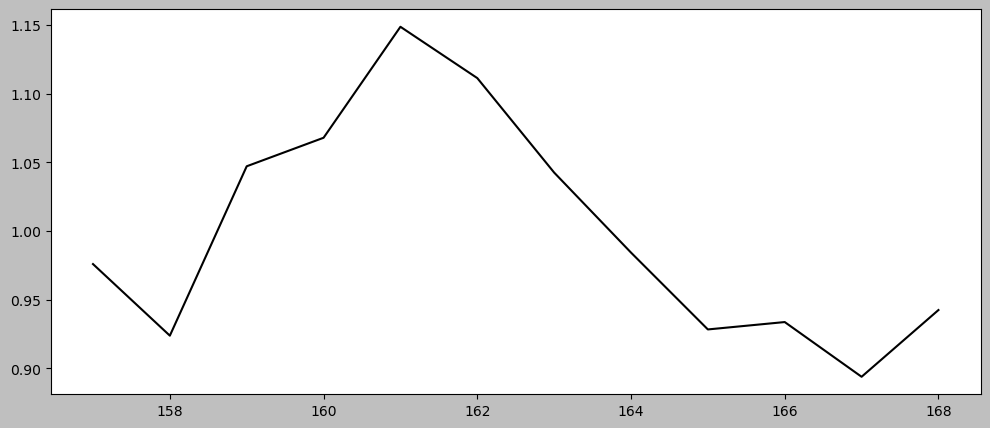

In [66]:
components['seasonal'].plot(title='Seasoanl Component')

In [72]:
intervals = results.prediction_intervals(steps=n, theta=2)
print(intervals)

          lower        upper
157  754.502241   931.025494
158  673.763431   923.405012
159  753.286267  1059.033515
160  748.579355  1101.625867
161  798.795497  1193.513498
162  748.562726  1180.954631
163  672.471536  1139.508173
164  606.607354  1105.890521
165  543.633580  1073.203349
166  534.840716  1093.056267
167  487.294532  1072.755940
168  517.549714  1129.044213


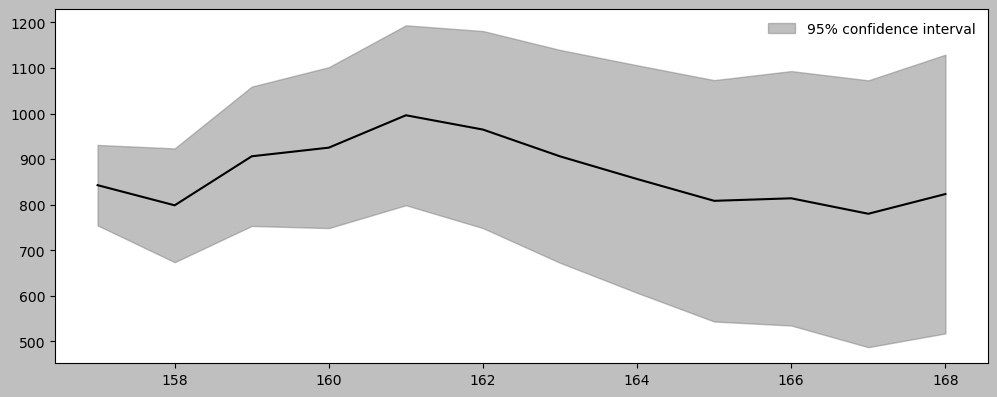

In [84]:
results.plot_predict(steps=n, theta=2, figsize=(10,4), alpha=0.05);

In [139]:
# test.plot()

# Recipe 3. Forecasting Multivariate Time Series Data using VAR

**VAR(1) Formula Example**
$$
\Large y_{(1),t} = \alpha_{1} + \theta_{11}y_{(1),t-1} + \theta_{12}y_{(2), t-1} + \epsilon_{(1),t} \\\Large y_{(2),t} = \alpha_{2} + \theta_{21}y_{(1),t-1} + \theta_{22}y_{(2),t-1} + \epsilon_{(2),t} 
\\~\\
\\~\\ 
\Large \begin{bmatrix} y_{(1),t} \\ y_{(2),t} \end{bmatrix} = 
\Large \begin{bmatrix} \alpha_{1} \\ \alpha_{2} \end{bmatrix} + \begin{bmatrix} \theta_{11} & \theta_{12} \\ \theta_{21} &  \theta_{22} \end{bmatrix}  \begin{bmatrix} y_{(1),t-1} \\ y_{(2), t-1} \end{bmatrix} + \begin{bmatrix} \epsilon_{(1),t} \\ \epsilon_{(2),t} \end{bmatrix}
$$

In [8]:
import pandas_datareader.data as web
from statsmodels.tsa.api import VAR, adfuller, kpss
from statsmodels.graphics.tsaplots import (plot_acf, 
                                           plot_pacf, 
                                           plot_ccf)
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.tools import diff

In [9]:
import statsmodels as sm
import matplotlib as mp

In [14]:

start = "01-01-1990"
end = "01-01-2025"
economic_df = web.FredReader(
        symbols=["FEDFUNDS", "unrate"], 
        start=start,
        end=end).read()

In [307]:
#you can store the file for future reference (uncomment below)
# file = '../../datasets/Ch11/economic_df.pickle'
# economic_df.to_pickle(file)
# read the pickle file
# economic_df = pd.read_pickle(file)

#  you can store as CSV to read later 
# economic_df.to_csv('../../datasets/Ch11/economic_df.csv', index=True)

# Read the CSV
# economic_df = pd.read_csv('../../datasets/Ch11/economic_df.csv', parse_dates=['DATE'], index_col=['DATE'])

In [16]:
economic_df.head()

FEDFUNDS  unrate
DATE                        
1990-01-01      8.23     5.4
1990-02-01      8.24     5.3
1990-03-01      8.28     5.2
1990-04-01      8.26     5.4
1990-05-01      8.18     5.4

In [18]:
economic_df.tail()

FEDFUNDS  unrate
DATE                        
2024-09-01      5.13     4.1
2024-10-01      4.83     4.1
2024-11-01      4.64     4.2
2024-12-01      4.48     4.1
2025-01-01      4.33     4.0

In [20]:
economic_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 1990-01-01 to 2025-01-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FEDFUNDS  421 non-null    float64
 1   unrate    421 non-null    float64
dtypes: float64(2)
memory usage: 9.9 KB


In [22]:
economic_df.index.freq = 'MS'

In [24]:
economic_df.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='DATE', length=421, freq='MS')

In [26]:
economic_df.isna().sum()

FEDFUNDS    0
unrate      0
dtype: int64

In [28]:
economic_df.shape

(421, 2)

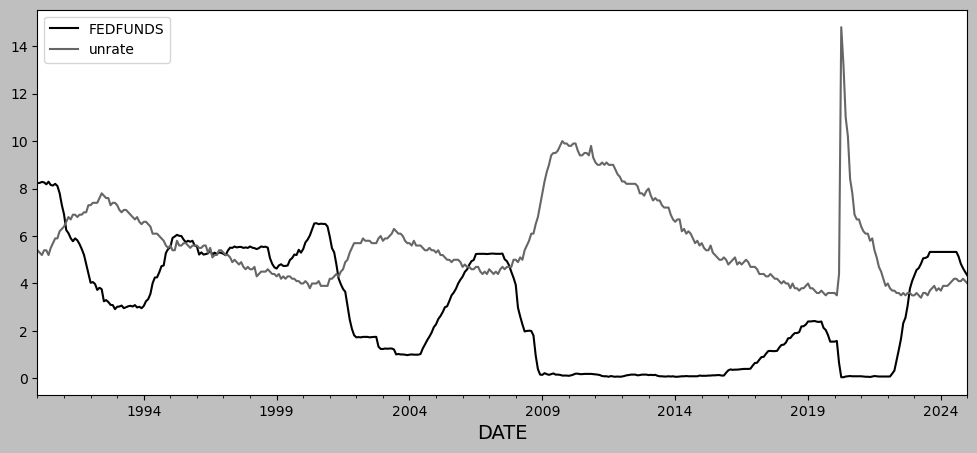

In [30]:
economic_df.plot();

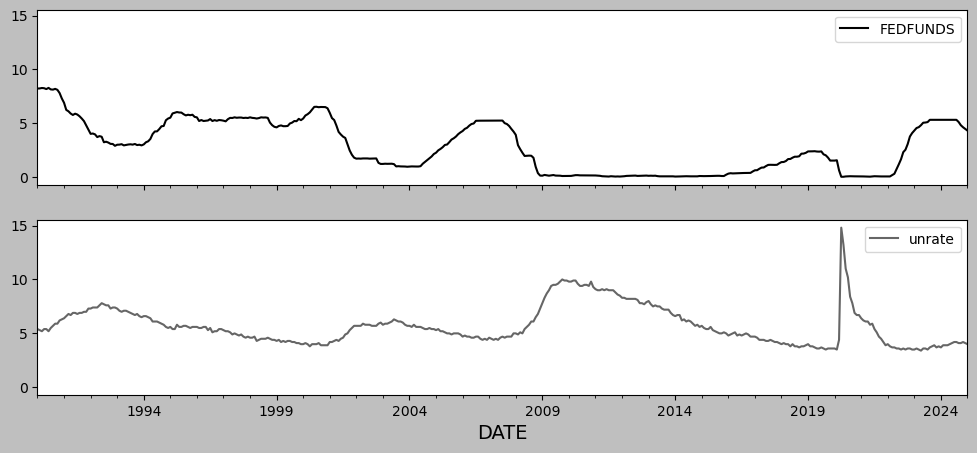

In [32]:
economic_df.plot(subplots=True, sharey=True);

In [34]:
correlation_matrix = economic_df.corr()
print(correlation_matrix)

          FEDFUNDS    unrate
FEDFUNDS  1.000000 -0.439248
unrate   -0.439248  1.000000


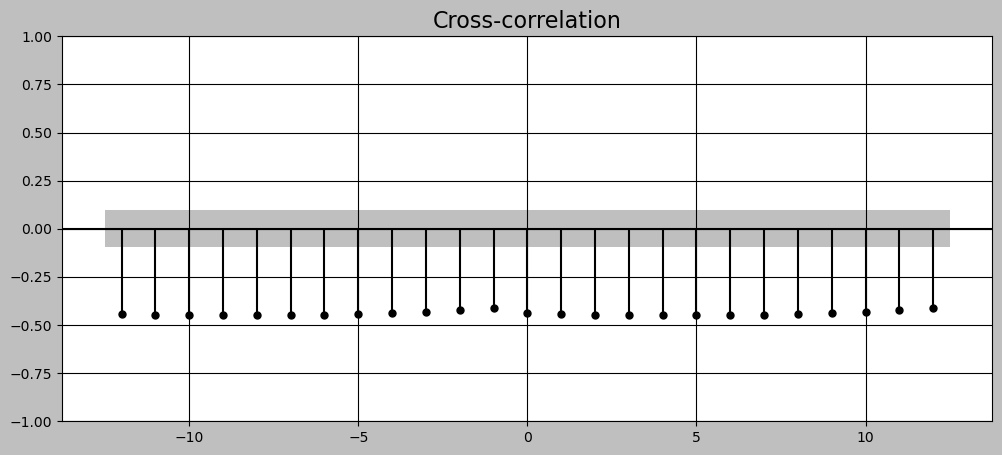

In [36]:
from statsmodels.graphics.tsaplots import ccf, plot_ccf
import numpy as np

# Calculate the cross-correlation between FEDFUNDS and unrate
lags = np.arange(-12, 13)  # Limiting the lag to 12 months ahead and behind for better interpretability
cross_corr_values = ccf(economic_df['FEDFUNDS'], economic_df['unrate'])

# Plot the cross-correlation function
# plt.figure(figsize=(10, 6))
# plt.stem(lags, cross_corr_values[:len(lags)], use_line_collection=True)
# plt.title('Cross-Correlation Function between FEDFUNDS and Unrate')
# plt.xlabel('Lag')
# plt.ylabel('Cross-Correlation')
# plt.grid(True)
# plt.show()
#plt.figure(figsize=(10, 5))
plot_ccf(economic_df['FEDFUNDS'], economic_df['unrate'], lags=lags)
plt.grid(True)

In [172]:
# import matplotlib.pyplot as plt
# from statsmodels.graphics.tsaplots import plot_ccf

# # Adjust figure size and styling
# plt.figure(figsize=(10, 5))
# plt.style.use('default')  # Reset to a cleaner style

# # Plot the CCF with better formatting
# plot_ccf(economic_df['FEDFUNDS'], economic_df['unrate'], lags=np.arange(-12, 13))
# plt.grid(True)
# plt.show()


In [174]:
# def check_stationarity(df):
#     kps = kpss(df)
#     adf = adfuller(df)
    
#     kpss_pv, adf_pv = kps[1], adf[1]
#     kpssh, adfh = 'Stationary', 'Non-stationary'
    
#     if adf_pv < 0.05:
#         # Reject ADF Null Hypothesis
#         adfh = 'Stationary'
#     if kpss_pv < 0.05:
#         # Reject KPSS Null Hypothesis
#         kpssh = 'Non-stationary'
#     return (kpssh, adfh)

In [38]:
# def check_stationarity(series):
#     # KPSS Test (with 'ct' for trend; can use 'c' for constant only)
#     kpss_stat, kpss_p_value, *_ = kpss(series, regression='c', nlags="auto")
    
#     # ADF Test (with default lag structure)
#     adf_stat, adf_p_value, *_ = adfuller(series)
    
#     # Interpreting results
#     adf_result = 'Stationary' if adf_p_value < 0.05 else 'Non-stationary'
#     kpss_result = 'Non-stationary' if kpss_p_value < 0.05 else 'Stationary'
    
#     return {'ADF': adf_result, 'KPSS': kpss_result}

# # Applying the check_stationarity function to each time series column
# for col in economic_df.columns:
#     results = check_stationarity(economic_df[col])
#     print(f'{col} ADF: {results["ADF"]}, KPSS: {results["KPSS"]}')


In [40]:
def check_stationarity(df):
    adf_pv = adfuller(df)[1]
    result = 'Stationary' if adf_pv < 0.05 else "Non-Stationary"
    return result

In [44]:
for i in economic_df:
    adf = check_stationarity(economic_df[i])
    print(f'{i} adf: {adf}')

FEDFUNDS adf: Stationary
unrate adf: Stationary


The data for testing whether the time series in the second column Granger
causes the time series in the first column. Missing values are not
supported.

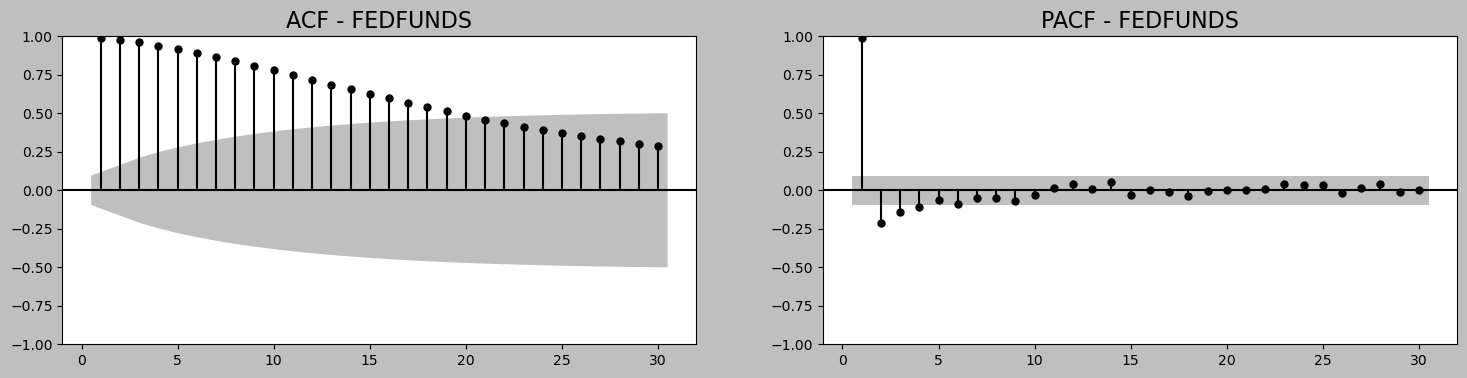

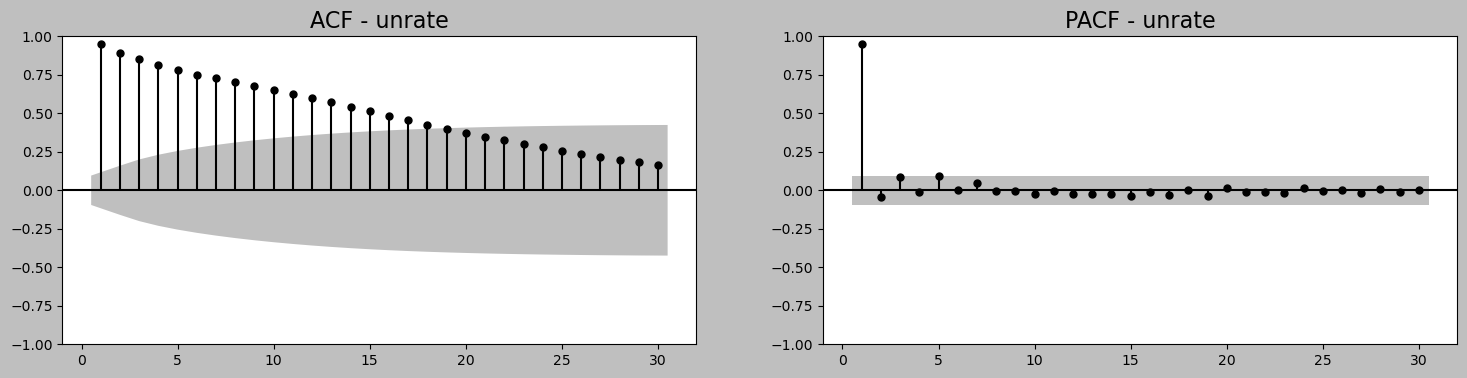

In [46]:
for col in economic_df.columns:
    fig, ax = plt.subplots(1,2, figsize=(18,4))
    plot_acf(economic_df[col], zero=False, 
             lags=30, ax=ax[0], title=f'ACF - {col}')
    plot_pacf(economic_df[col], zero=False, 
              lags=30, ax=ax[1], title=f'PACF - {col}');

In [147]:
train, test = split_data(economic_df, test_split=12)

train: 409 , test: 12


In [149]:
# train = economic_df.loc[:'2023']
# test = economic_df.loc['2024':]

In [151]:
train.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
               '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01',
               '2023-12-01', '2024-01-01'],
              dtype='datetime64[ns]', name='DATE', length=409, freq='MS')

In [153]:
test.index

DatetimeIndex(['2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS')

In [155]:
print(f'Train: {len(train)}, Test: {len(test)}')

Train: 409, Test: 12


In [157]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
scale.fit(train)
train_sc = pd.DataFrame(scale.transform(train),
                        index=train.index,
                        columns=train.columns)
test_sc = pd.DataFrame(scale.transform(test), 
                       index=test.index,
                       columns=test.columns)

In [159]:
test[0:5]

FEDFUNDS  unrate
DATE                        
2024-02-01      5.33     3.9
2024-03-01      5.33     3.9
2024-04-01      5.33     3.9
2024-05-01      5.33     4.0
2024-06-01      5.33     4.1

In [161]:
scale.inverse_transform(test_sc)[0:5]

array([[5.33, 3.9 ],
       [5.33, 3.9 ],
       [5.33, 3.9 ],
       [5.33, 4.  ],
       [5.33, 4.1 ]])

<Axes: xlabel='DATE'>

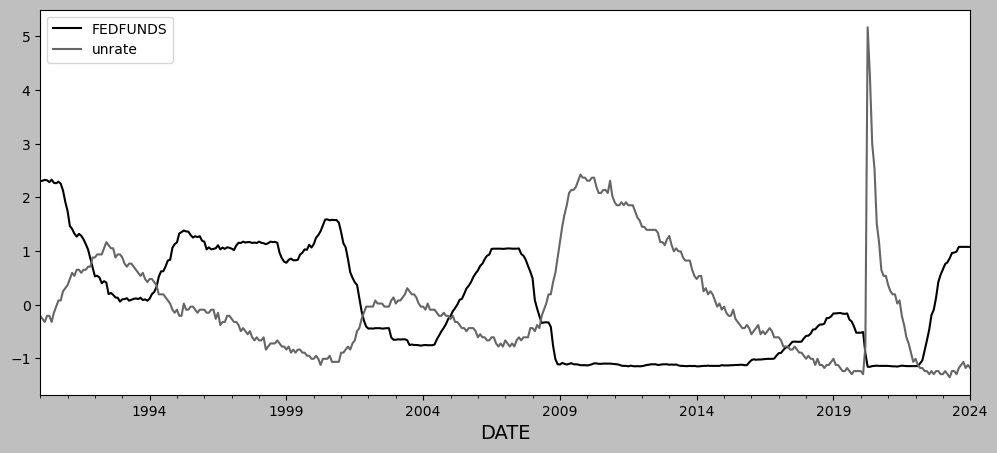

In [163]:
train_sc.plot()

In [165]:
train_sc.shape

(409, 2)

In [167]:
test_sc.shape

(12, 2)

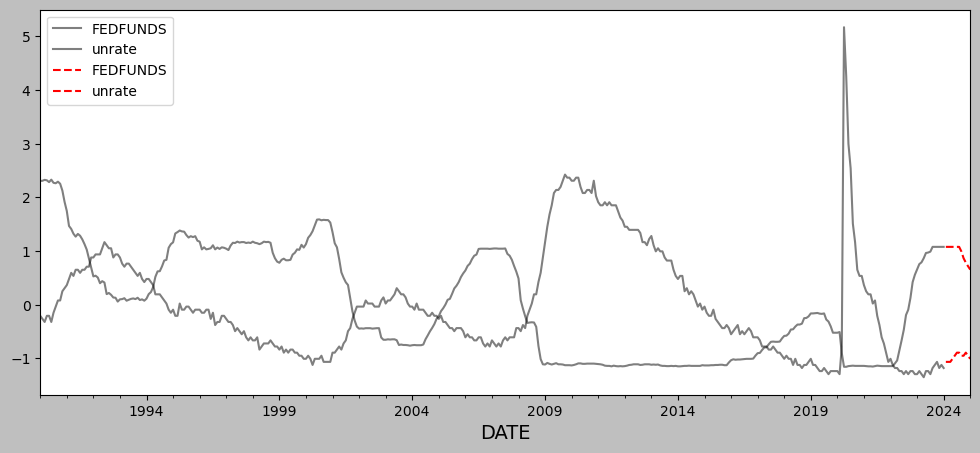

In [169]:
ax = train_sc.plot(style='k', alpha=0.5, label='train')
test_sc.plot(ax=ax, style='r--', label='test')
plt.legend(); plt.show()

In [171]:
model = VAR(endog=train_sc)
res = model.select_order(maxlags=10)
res.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [173]:
res

In [175]:
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.3054     -0.2854      0.7369     -0.2975
1       -7.408      -7.348   0.0006064      -7.384
2       -7.941      -7.841   0.0003559      -7.901
3       -8.026     -7.886*   0.0003269     -7.971*
4       -8.029      -7.850   0.0003257      -7.958
5       -8.022      -7.802   0.0003281      -7.935
6       -8.039      -7.779   0.0003227      -7.936
7      -8.046*      -7.746  0.0003205*      -7.927
8       -8.028      -7.688   0.0003261      -7.894
9       -8.017      -7.638   0.0003297      -7.867
10      -8.004      -7.584   0.0003343      -7.837
--------------------------------------------------


In [177]:
print(res.selected_orders)

{'aic': 7, 'bic': 3, 'hqic': 3, 'fpe': 7}


In [179]:
print(f'AIC: {res.aic} , BIC: {res.bic}, \
      HQ: {res.hqic}, FPE: {res.fpe}')

AIC: 7 , BIC: 3,       HQ: 3, FPE: 7


In [181]:
results = model.fit(ic='bic')

In [183]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Feb, 2025
Time:                     13:01:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.90565
Nobs:                     406.000    HQIC:                  -7.98912
Log likelihood:           494.713    FPE:                0.000321089
AIC:                     -8.04380    Det(Omega_mle):     0.000310297
--------------------------------------------------------------------
Results for equation FEDFUNDS
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.000916         0.002946           -0.311           0.756
L1.FEDFUNDS         1.510621         0.049160           30.728           0.000
L1.unrate           0.021657         0.009675            2.238   

In [98]:
type(results)

statsmodels.tsa.vector_ar.var_model.VARResultsWrapper

In [185]:
lag_order = results.k_ar
lag_order

3

In [187]:
results.params

FEDFUNDS    unrate
const       -0.000916 -0.004873
L1.FEDFUNDS  1.510621 -1.980463
L1.unrate    0.021657  0.961085
L2.FEDFUNDS -0.313532  3.059935
L2.unrate   -0.013225 -0.083032
L3.FEDFUNDS -0.206062 -1.100000
L3.unrate   -0.010698  0.060910

In [189]:
train_sc[-lag_order:]

FEDFUNDS    unrate
DATE                          
2023-11-01  1.079207 -1.177851
2023-12-01  1.079207 -1.120650
2024-01-01  1.079207 -1.177851

<Axes: xlabel='DATE'>

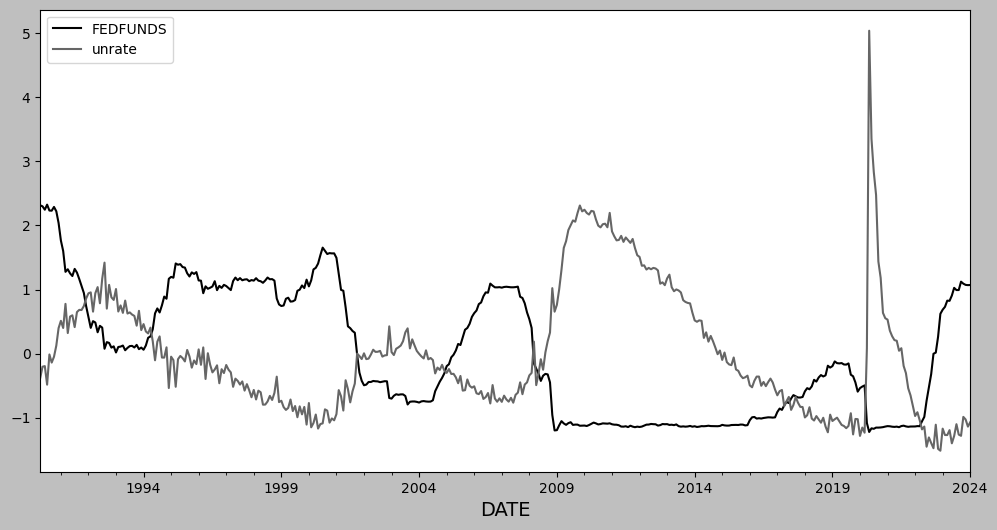

In [191]:
results.fittedvalues.plot(figsize=(12,6))

array([<Axes: xlabel='DATE'>, <Axes: xlabel='DATE'>], dtype=object)

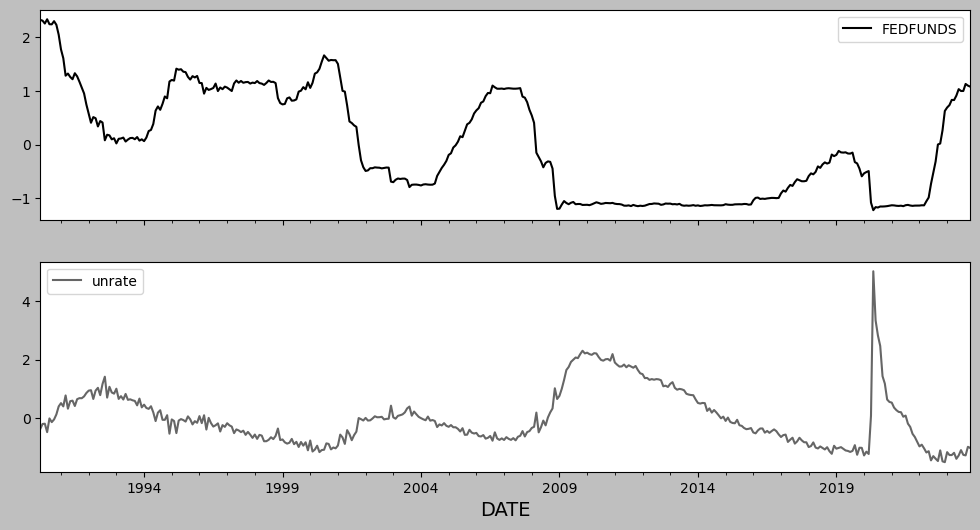

In [108]:
results.fittedvalues.plot(figsize=(12,6), subplots=True)

**Manually creating a similar plot**

In [193]:
past_y = train_sc[-lag_order:].values
n = test_sc.shape[0]
forecast, lower, upper = results.forecast_interval(y=past_y, steps=n)

In [195]:
forecast_df = pd.DataFrame(scale.inverse_transform(forecast), 
                           index=test_sc.index, 
                           columns=test_sc.columns)
lower_df = pd.DataFrame(scale.inverse_transform(lower), 
                        index=test_sc.index, 
                        columns=test_sc.columns)
upper_df = pd.DataFrame(scale.inverse_transform(upper), 
                        index=test_sc.index, 
                        columns=test_sc.columns)


In [197]:
# forecast = scale.inverse_transform(forecast)
# lower = scale.inverse_transform(lower)
# upper = scale.inverse_transform(upper)

In [199]:
# forecast_df = pd.DataFrame(forecast, index=test_sc.index, columns=test_sc.columns)
# pd.DataFrame(lower, index=test_sc.index, columns=test_sc.columns)



In [201]:
# forecast, lower, upper = results.forecast_interval(past_y, steps=n)

# idx = test.index
# style = 'k--'
# ax = train_sc.iloc[:-lag_order, 1].plot(figsize=(10, 4), style='k')
# pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
# pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
# pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
# plt.title('Forecasting Unemployment Rate (unrate)')
# plt.show()

Alternatively you can also use `fill_between`

In [204]:
# forecast, lower, upper = results.forecast_interval(past_y, steps=n)

# idx = test.index; style = 'k--'
# ax = train_sc.iloc[:-lag_order, 1].plot(style='k')
# pred_forecast  = pd.Series(forecast[:, 1], index=idx).plot(ax=ax, style=style)
# pred_lower = pd.Series(lower[:, 1], index=idx).plot(ax=ax, style=style)
# pred_upper  = pd.Series(upper[:, 1], index=idx).plot(ax=ax, style=style)
# plt.fill_between(idx, lower[:,1], upper[:,1], alpha=0.12)
# plt.title('Forecasting Unemployment Rate (unrate)')
# plt.legend(['Train','Forecast']);plt.show()


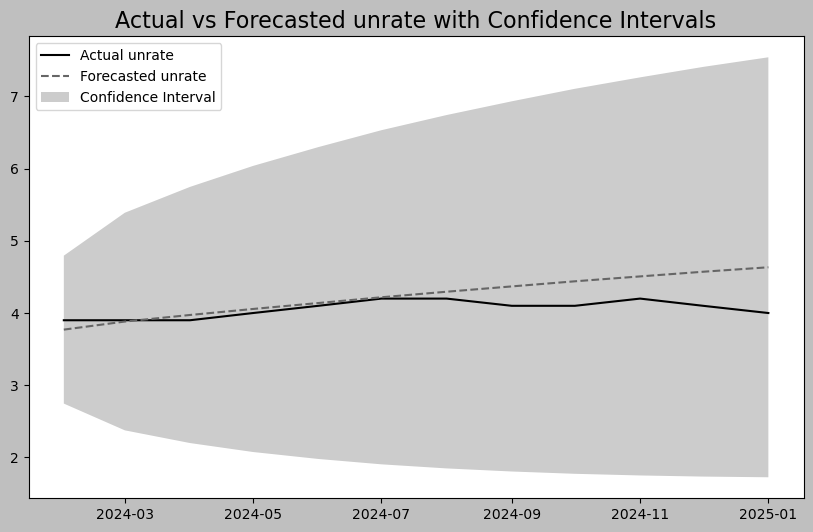

In [206]:
idx = test.index
plt.figure(figsize=(10, 6))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, forecast_df['unrate'], label='Forecasted unrate', linestyle='dashed')
plt.fill_between(idx, lower_df['unrate'], upper_df['unrate'], alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Forecasted unrate with Confidence Intervals')
plt.legend()
plt.show()

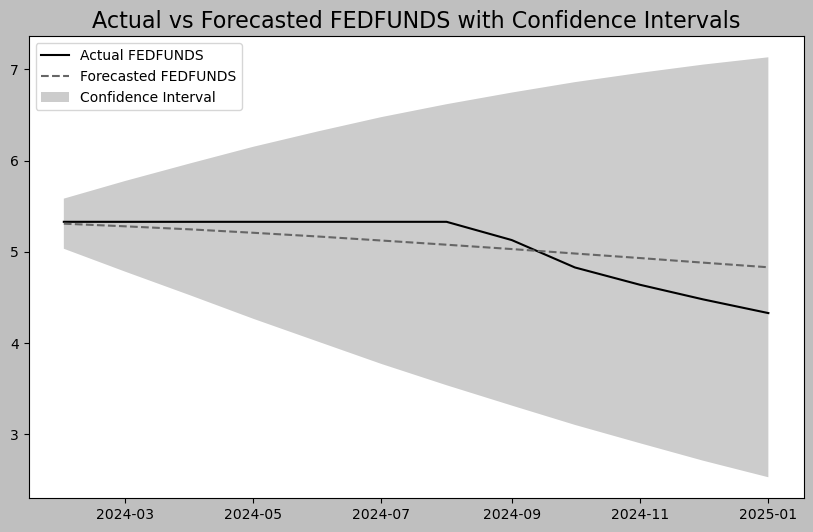

In [208]:
idx = test.index
plt.figure(figsize=(10, 6))
plt.plot(idx, test['FEDFUNDS'], label='Actual FEDFUNDS')
plt.plot(idx, forecast_df['FEDFUNDS'], label='Forecasted FEDFUNDS', linestyle='dashed')
plt.fill_between(idx, lower_df['FEDFUNDS'], upper_df['FEDFUNDS'], alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Forecasted FEDFUNDS with Confidence Intervals')
plt.legend()
plt.show()

## There is more
* Comparing the results from VAR(3) with an AR(3) 
* AR(3) is a univariate this way we are comparing using one variable (unrate) to see if using two variables are better or not
* Using ARIMA(3, 0, 0) indicates an AR(3)

In [210]:
from statsmodels.tsa.arima.model import ARIMA
lag_order

3

In [212]:
model = ARIMA(train['unrate'], 
              order=(lag_order,0,0)).fit()

In [214]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 unrate   No. Observations:                  409
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -341.764
Date:                Tue, 11 Feb 2025   AIC                            693.528
Time:                        13:02:54   BIC                            713.596
Sample:                    01-01-1990   HQIC                           701.468
                         - 01-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.6526      1.728      3.271      0.001       2.265       9.040
ar.L1          0.9952      0.024     42.326      0.000       0.949       1.041
ar.L2         -0.1359      0.041     -3.303      0.001      -0.217      -0.055
ar.L3          0.0900      0.034      2.679      0.007       0.024       0.156
sigma2         0.3097      0.008     40.542      0.000       0.295       0.325
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):           1378690.32
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              37.67   Skew:                            15.31
Prob(H) (two-sided):                  0.00   Kurtosis:                       285.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

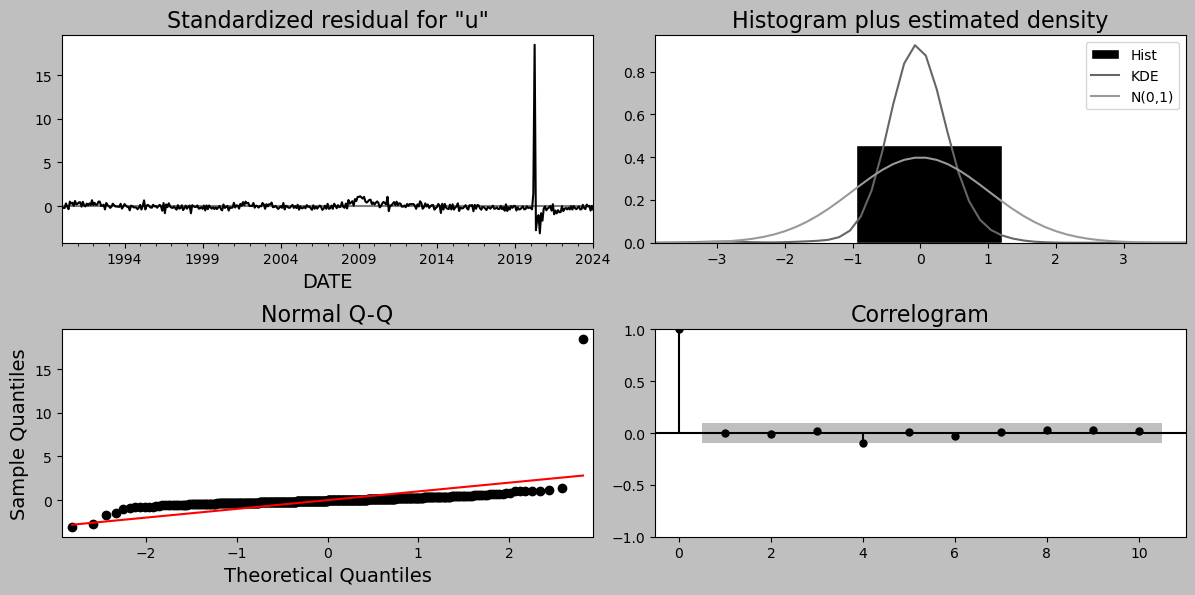

In [216]:
fig = model.plot_diagnostics(figsize=(12,6));
fig.tight_layout();plt.show()

In [218]:
ar_forecast = pd.Series(model.forecast(n), index=test.index)

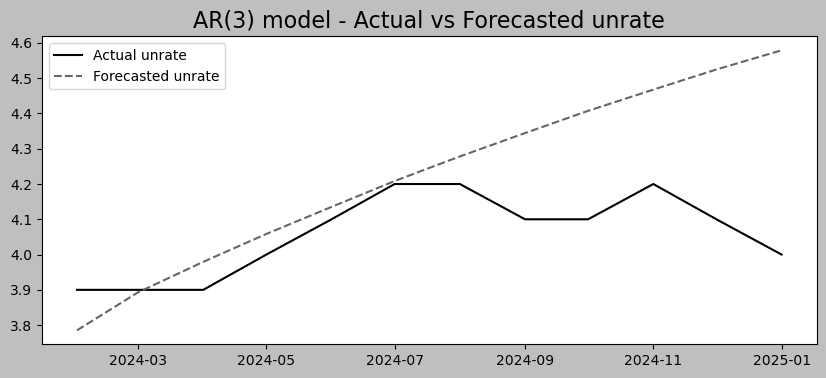

In [220]:
# Plotting the results from an AR(3)
idx = test.index
plt.figure(figsize=(10, 4))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, ar_forecast, label='Forecasted unrate', linestyle='dashed')
plt.title('AR(3) model - Actual vs Forecasted unrate')
plt.legend()
plt.show()
# plt.title('AR(3) Model - Forecast vs Actual')
# test['unrate'].plot(style='--', alpha=0.45, figsize=(12, 4))
# ar_forecast.plot()
# plt.legend(['test', 'Forecast']);

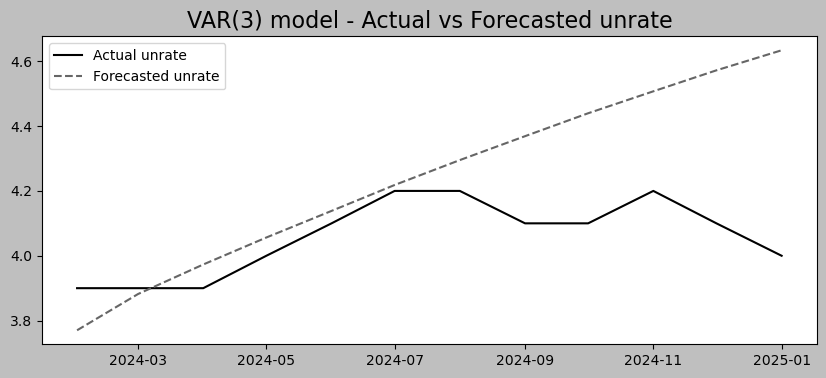

In [222]:
# plotting VAR(3) same code as before but without confidence intervals 
idx = test.index
plt.figure(figsize=(10, 4))
plt.plot(idx, test['unrate'], label='Actual unrate')
plt.plot(idx, forecast_df['unrate'], label='Forecasted unrate', linestyle='dashed')
plt.title('VAR(3) model - Actual vs Forecasted unrate')
plt.legend()
plt.show()

In [224]:
from statsmodels.tools.eval_measures import rmse
rmse_var = rmse(test['FEDFUNDS'], forecast_df['unrate'])
print('VAR(3) RMSE = ', rmse_var)

rmse_ar = rmse(test['FEDFUNDS'], ar_forecast)
print('AR(3) RMSE = ', rmse_ar)

VAR(3) RMSE =  1.0234912944493626
AR(3) RMSE =  1.0235946950213852


# Recipe 4. Evaluating vector autoregressive (VAR) models

In [288]:
# from statsmodels.tsa.api import VAR
# model = VAR(economic_df[['unrate', 'FEDFUNDS']])
# lag_order_selection = model.select_order(maxlags=12)
# print(lag_order_selection.summary())


In [226]:
granger = grangercausalitytests(
            x=economic_df[['unrate', 'FEDFUNDS']], 
            maxlag=3)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5935  , p=0.4415  , df_denom=417, df_num=1
ssr based chi2 test:   chi2=0.5977  , p=0.4394  , df=1
likelihood ratio test: chi2=0.5973  , p=0.4396  , df=1
parameter F test:         F=0.5935  , p=0.4415  , df_denom=417, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=21.5087 , p=0.0000  , df_denom=414, df_num=2
ssr based chi2 test:   chi2=43.5370 , p=0.0000  , df=2
likelihood ratio test: chi2=41.4205 , p=0.0000  , df=2
parameter F test:         F=21.5087 , p=0.0000  , df_denom=414, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=21.7341 , p=0.0000  , df_denom=411, df_num=3
ssr based chi2 test:   chi2=66.3128 , p=0.0000  , df=3
likelihood ratio test: chi2=61.5503 , p=0.0000  , df=3
parameter F test:         F=21.7341 , p=0.0000  , df_denom=411, df_num=3


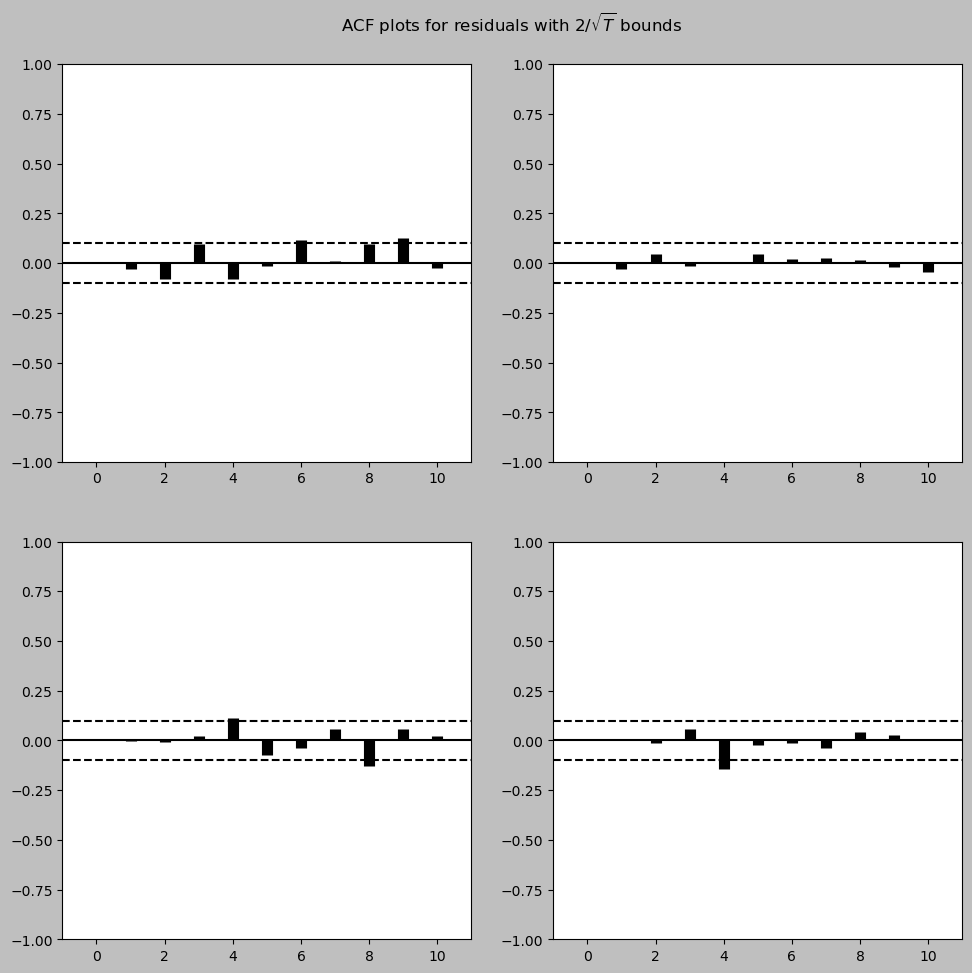

In [252]:
results.plot_acorr(resid=True);

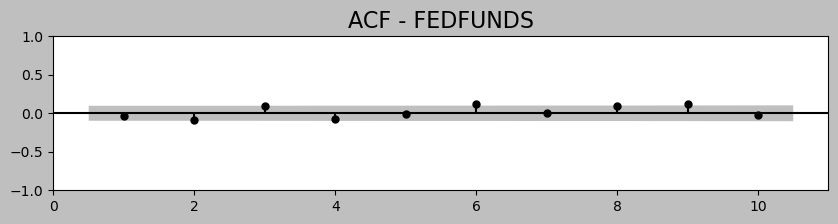

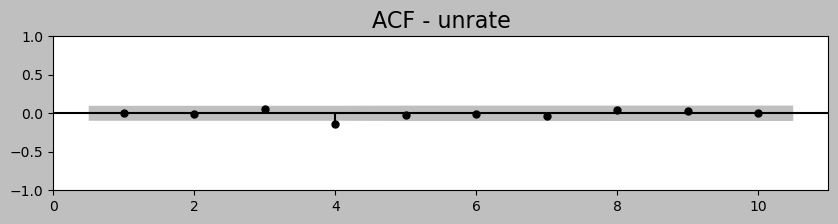

In [232]:
# You can plot your ACF on the resiuals as well using results.resid
for col in results.reresid.columns:
    fig, ax = plt.subplots(1,1, figsize=(10,2))
    plot_acf(results.resid[col], zero=False, 
             lags=10, ax=ax, title=f'ACF - {col}')

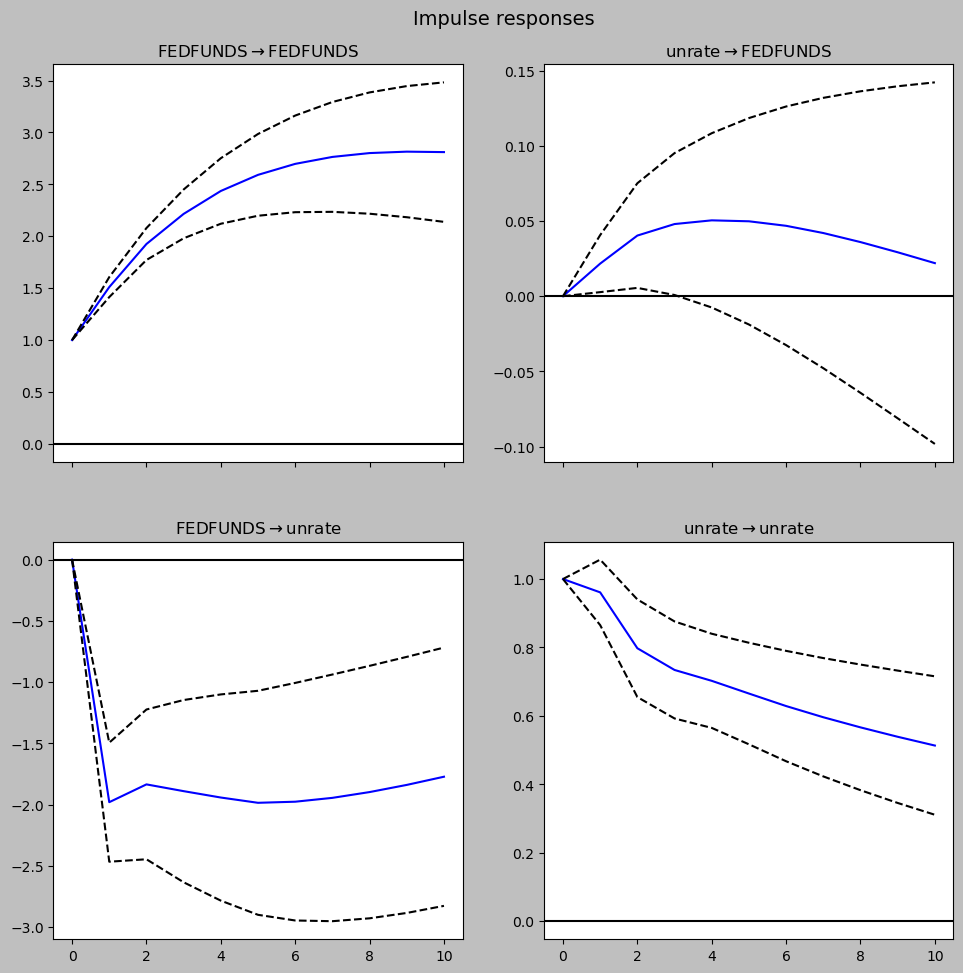

In [234]:
irf_output = results.irf()
irf_output.plot();

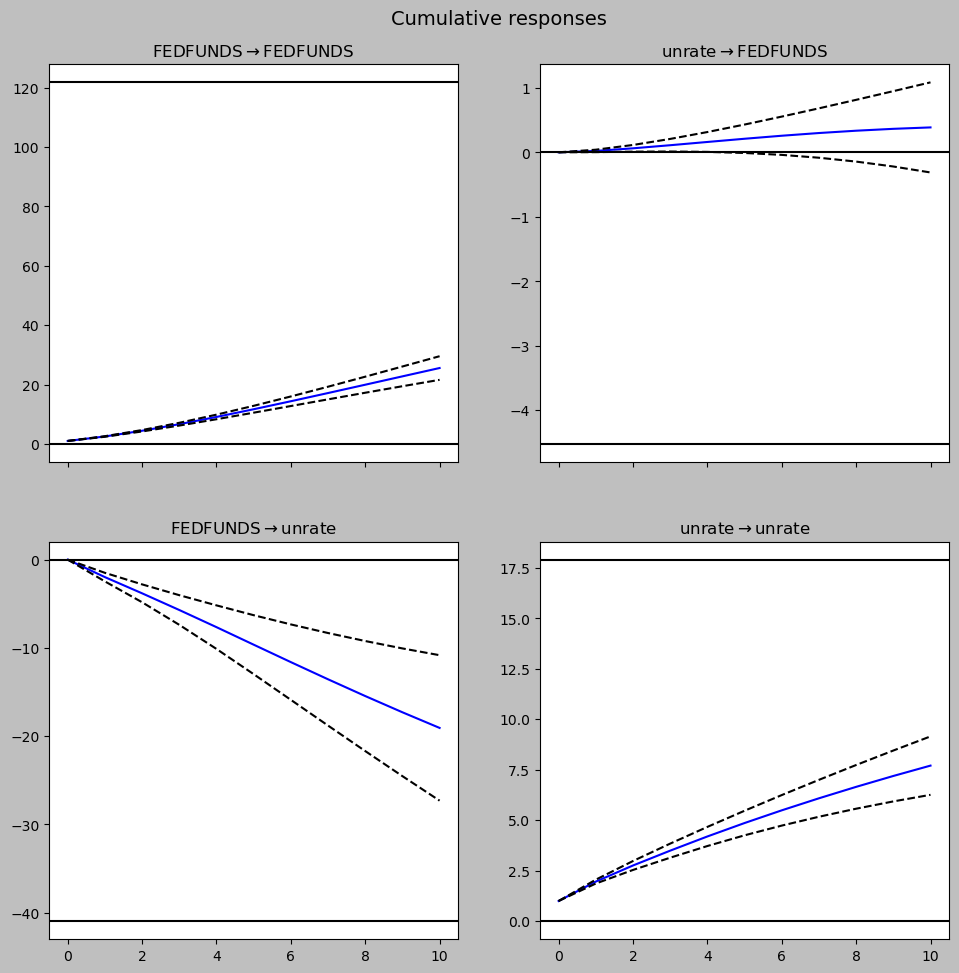

In [266]:
irf_output.plot_cum_effects();

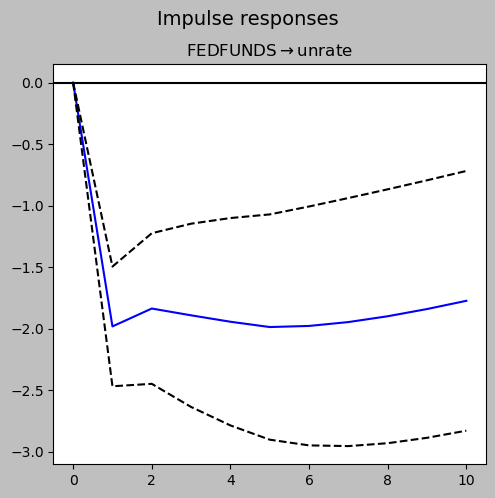

In [274]:
fig = irf_output.plot(impulse='FEDFUNDS', 
                      response='unrate', 
                      figsize=(5, 5))
fig.tight_layout();

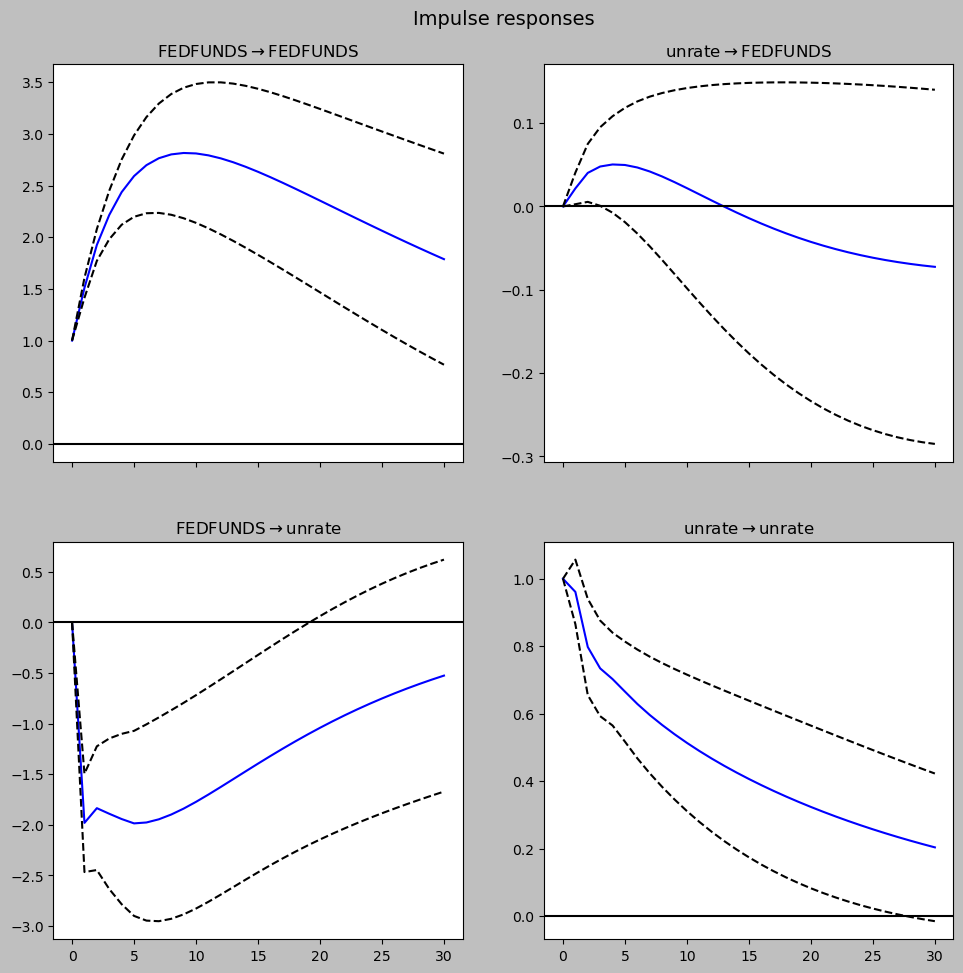

In [242]:
# Example changing lag value
irf_output = results.irf(30)
irf_output.plot();

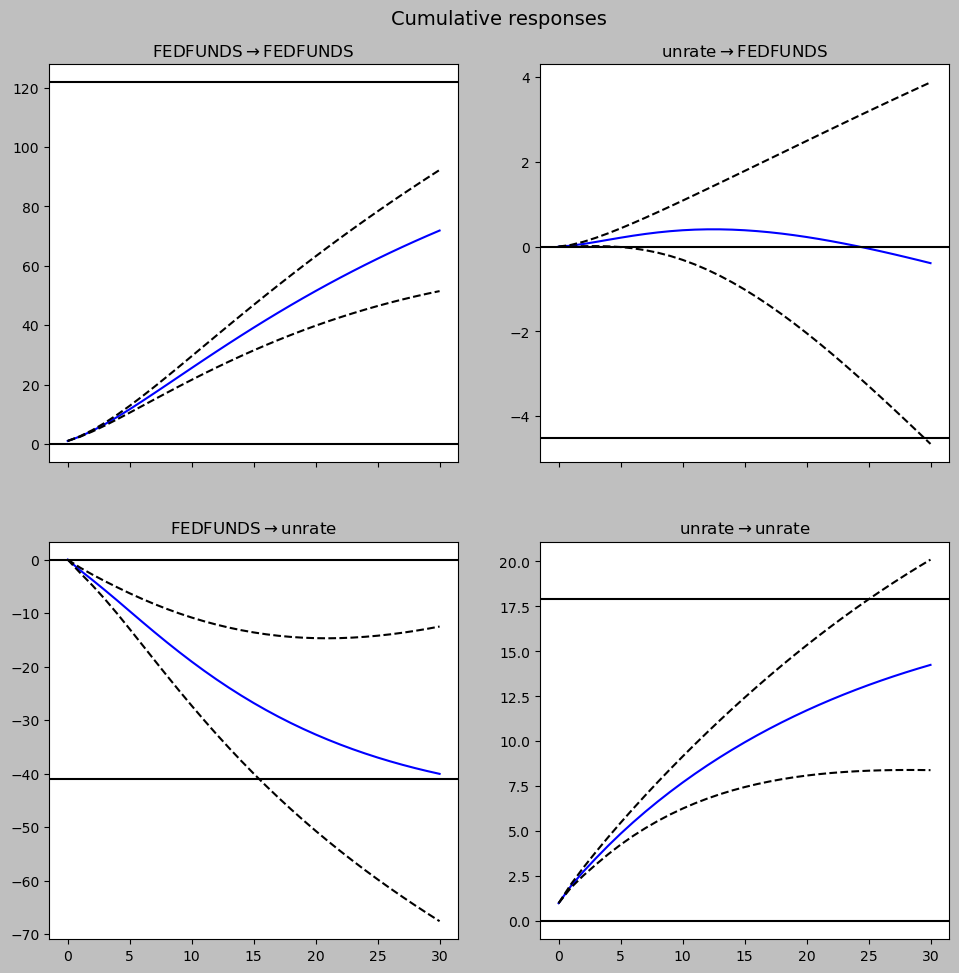

In [244]:
# Example changing lag value
irf_output.plot_cum_effects()
plt.show()

In [284]:
fv = results.fevd()
fv.summary()

FEVD for FEDFUNDS
     FEDFUNDS    unrate
0    1.000000  0.000000
1    0.996382  0.003618
2    0.992398  0.007602
3    0.990617  0.009383
4    0.990113  0.009887
5    0.990248  0.009752
6    0.990727  0.009273
7    0.991388  0.008612
8    0.992123  0.007877
9    0.992863  0.007137

FEVD for unrate
     FEDFUNDS    unrate
0    0.012945  0.987055
1    0.122431  0.877569
2    0.157258  0.842742
3    0.182204  0.817796
4    0.202023  0.797977
5    0.219171  0.780829
6    0.233564  0.766436
7    0.245645  0.754355
8    0.255788  0.744212
9    0.264306  0.735694




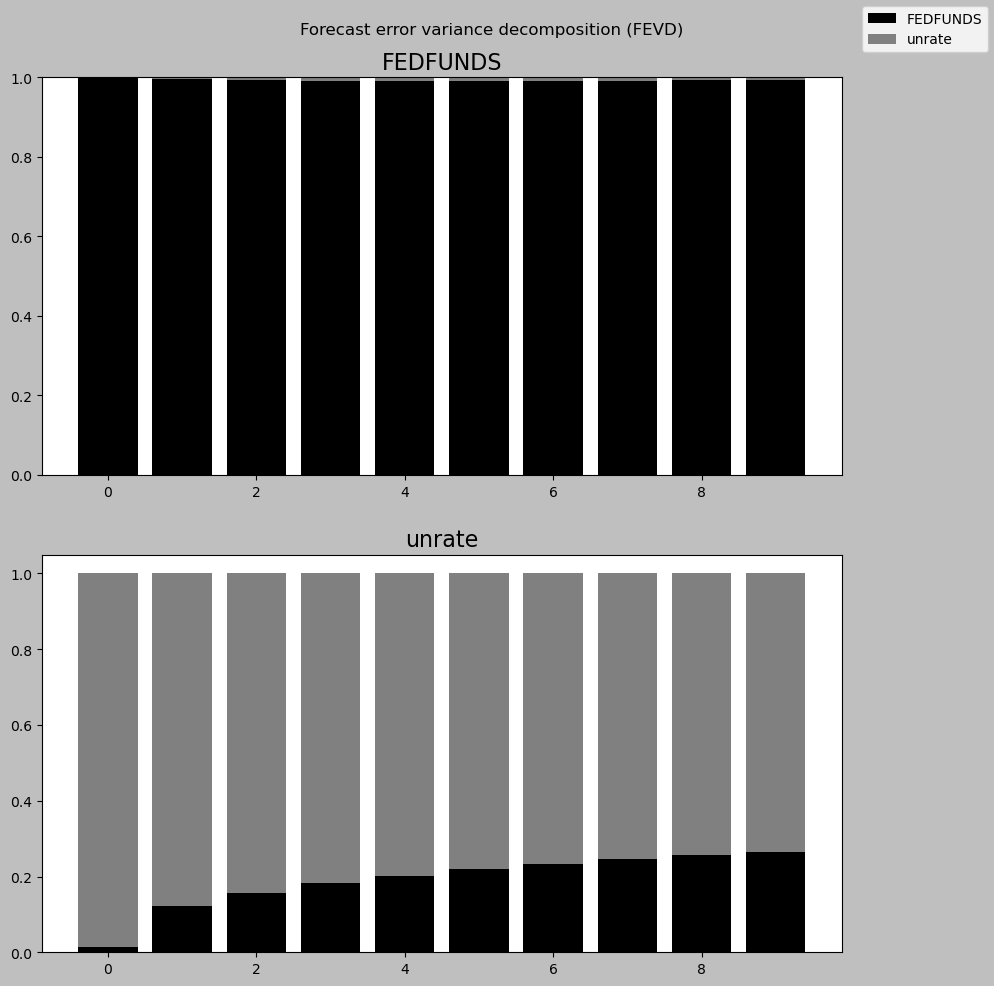

In [286]:
fv.plot()
plt.show()

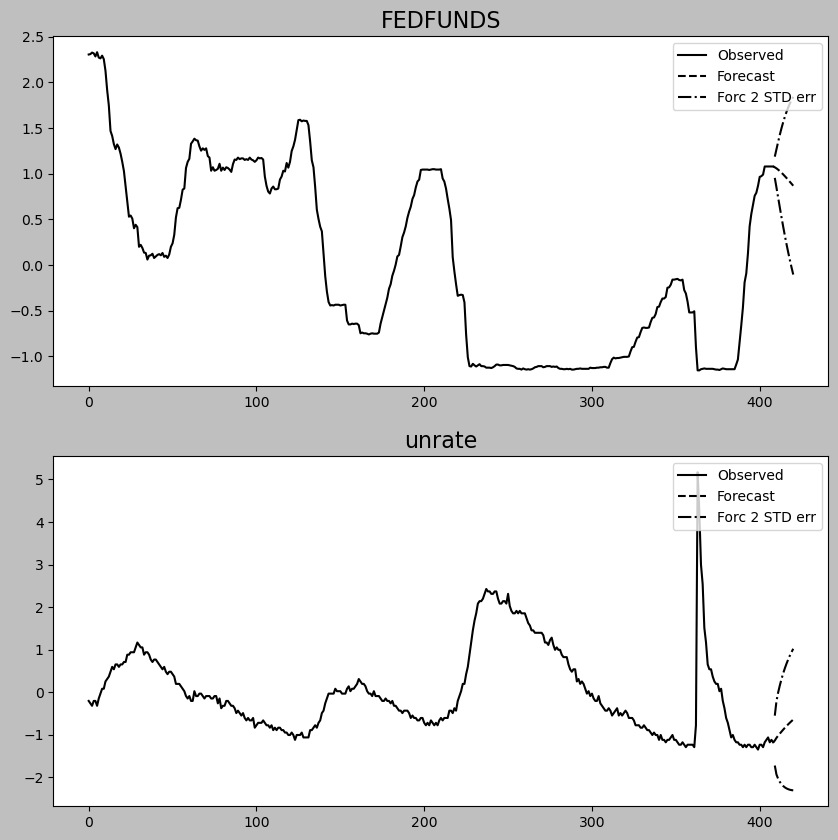

In [314]:
results.plot_forecast(steps=n, plot_stderr=True);

In [318]:
from statsmodels.tsa.api import VAR

# Assuming `economic_df` is your DataFrame containing FEDFUNDS and UNRATE
model = VAR(economic_df)
results = model.fit(maxlags=10, ic='aic')

In [320]:
# from statsmodels.tsa.vector_ar.svar_model import SVAR

# # Example of specifying an identity matrix for A and estimating B
# A = np.eye(2)  # Identity matrix for simplicity
# B = np.array([[np.nan, 0], [np.nan, np.nan]])  # Example structure with 'nan' for estimation

# svar_model = SVAR(economic_df, svar_type='B', A=A, B=B)
# svar_results = svar_model.fit(maxlags=results.k_ar)

# Recipe 5. Forecasting Volatility in Financial Time Series Data with GARCH

* To install arch using `pip`, use the following command:

```
pip install arch
```

* To install arch using `conda`, use the following command:

```
conda install arch-py -c conda-forge
```


In [323]:
# !conda install -c conda-forge arch-py -y

In [2]:
import arch

In [3]:
arch.__version__

'7.2.0'

In [326]:
from arch import arch_model

In [329]:
msft = pd.read_csv('../../datasets/Ch11/MSFT.csv', 
                   index_col='date', 
                    usecols=['date', 'close'],
                   parse_dates=True)
msft.head()

close
date                  
2019-09-04  131.457260
2019-09-05  133.768707
2019-09-06  132.861359
2019-09-09  131.352219
2019-09-10  129.976837

In [331]:
msft['returns'] = 100 * msft.pct_change()
msft.dropna(inplace=True, how='any')
msft.head()

close   returns
date                            
2019-09-05  133.768707  1.758326
2019-09-06  132.861359 -0.678297
2019-09-09  131.352219 -1.135876
2019-09-10  129.976837 -1.047094
2019-09-11  130.014984  0.029349

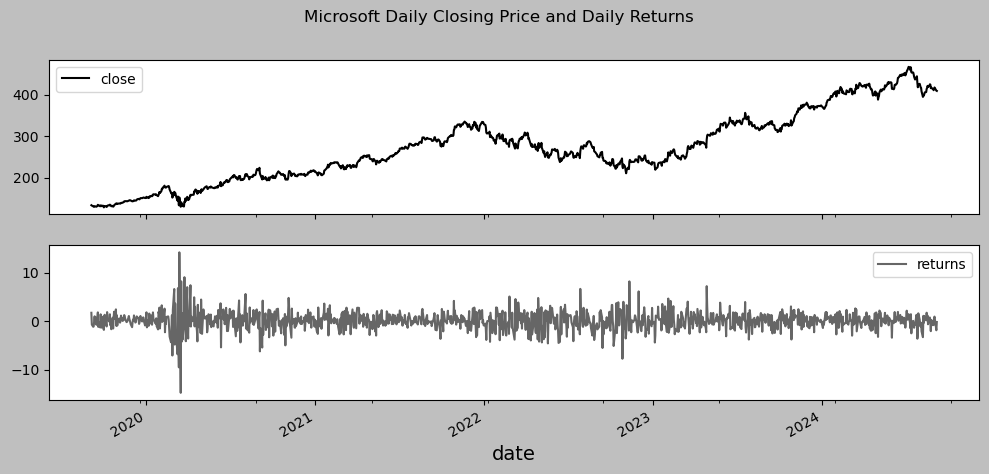

In [333]:
title = 'Microsoft Daily Closing Price and Daily Returns'
msft.plot(subplots=True, 
          title=title);

In [335]:
train = msft.returns[:-5]  
test = msft.returns[-5:]   

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (1253,)
Test: (5,)


In [337]:
train

date
2019-09-05    1.758326
2019-09-06   -0.678297
2019-09-09   -1.135876
2019-09-10   -1.047094
2019-09-11    0.029349
                ...   
2024-08-21   -0.155361
2024-08-22   -2.025281
2024-08-23    0.298405
2024-08-26   -0.791770
2024-08-27    0.084647
Name: returns, Length: 1253, dtype: float64

In [339]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='Constant',
                   vol='GARCH',
                   dist='normal')

In [341]:
results = model.fit(update_freq=3)

Iteration:      3,   Func. Count:     22,   Neg. LLF: 2419.4197011866704
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2409.599553434422
Iteration:      9,   Func. Count:     55,   Neg. LLF: 2409.592672855605
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2409.59267285418
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 9


In [343]:
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2409.59
Distribution:                  Normal   AIC:                           4827.19
Method:            Maximum Likelihood   BIC:                           4847.72
                                        No. Observations:                 1253
Date:                Wed, Jan 22 2025   Df Residuals:                     1252
Time:                        17:31:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1449  4.220e-02      3.433  5.973e-04 [6.216e-0

In [345]:
print(results.params)

mu          0.144878
omega       0.055152
alpha[1]    0.095416
beta[1]     0.891086
Name: params, dtype: float64


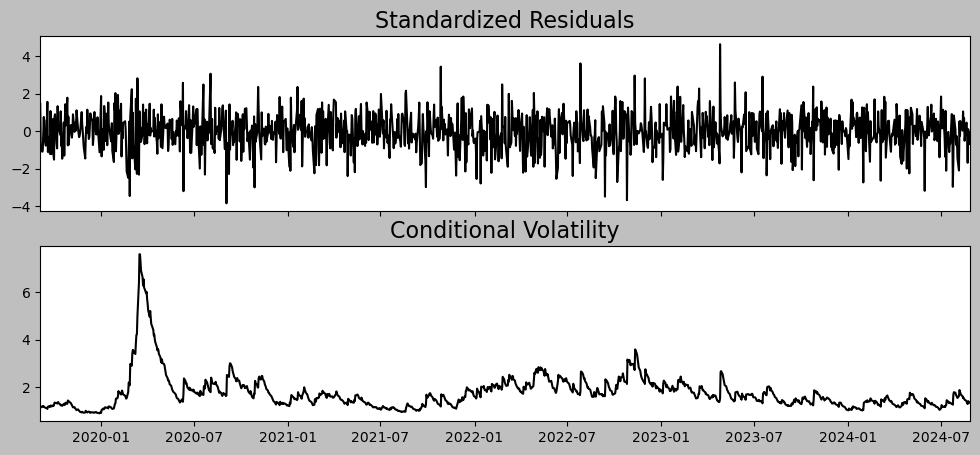

In [347]:
results.plot(); 

In [349]:
results.std_err

mu          0.042204
omega       0.035040
alpha[1]    0.025163
beta[1]     0.032043
Name: std_err, dtype: float64

Text(0.5, 1.0, 'Standardized Residuals')

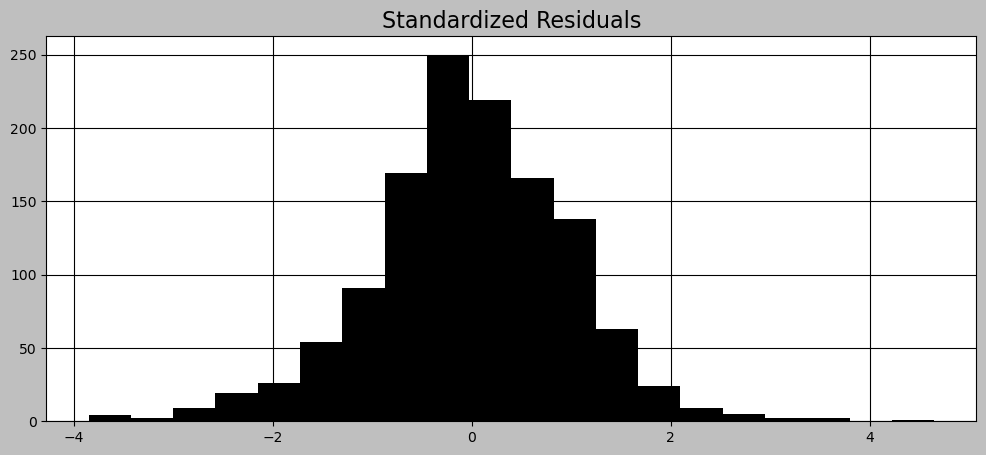

In [351]:
results.std_resid.hist(bins=20)
plt.title('Standardized Residuals')

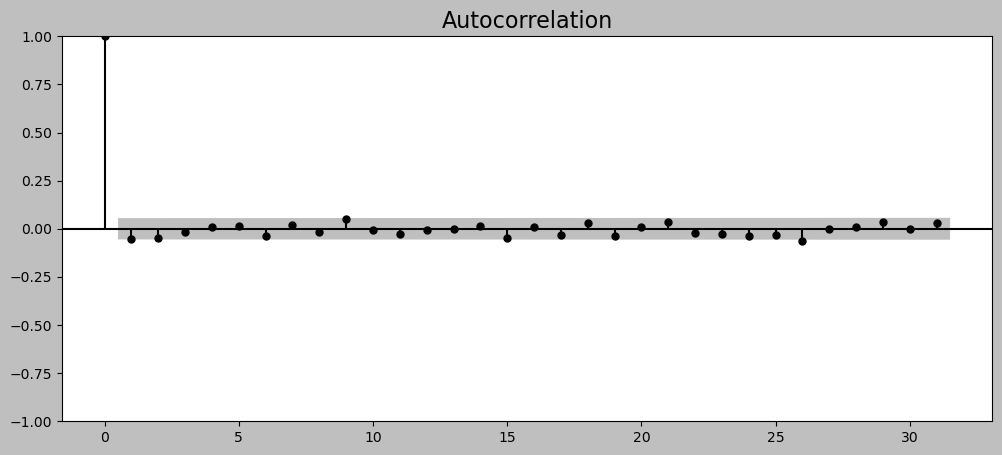

In [353]:
plot_acf(results.std_resid);plt.show()

In [355]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(results.std_resid, 
               lags=10, 
               return_df=True)['lb_pvalue']

1     0.050203
2     0.038038
3     0.077375
4     0.136003
5     0.195838
6     0.157237
7     0.201474
8     0.248204
9     0.153473
10    0.210838
Name: lb_pvalue, dtype: float64

In [357]:
test.shape[0]

5

In [359]:
msft_forecast = results.forecast(horizon=test.shape[0])

In [361]:
forecast = msft_forecast.variance
print(forecast)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


In [363]:
print(msft_forecast.mean.iloc[-3:])

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  0.144878  0.144878  0.144878  0.144878  0.144878


In [365]:
print(msft_forecast.variance)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


In [367]:
print(msft_forecast.mean)

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  0.144878  0.144878  0.144878  0.144878  0.144878


<Axes: xlabel='date'>

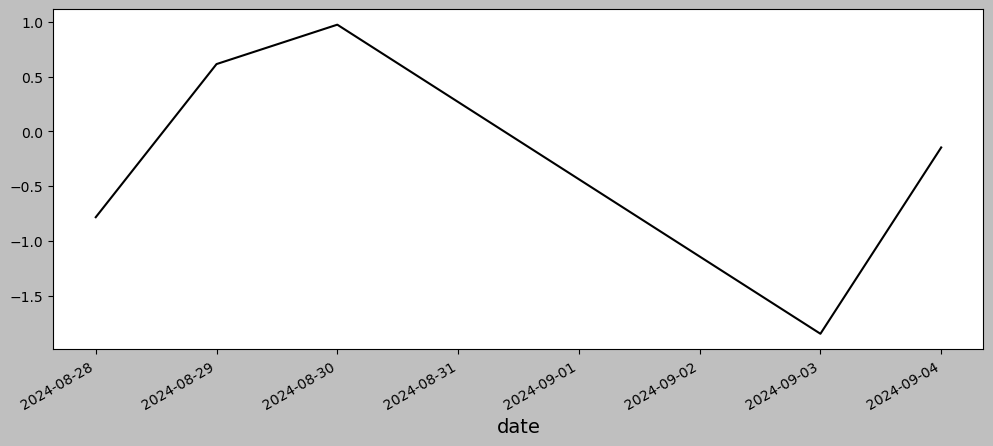

In [369]:
test.plot()

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-08-27  1.623692  1.656928  1.689714  1.722059  1.753967


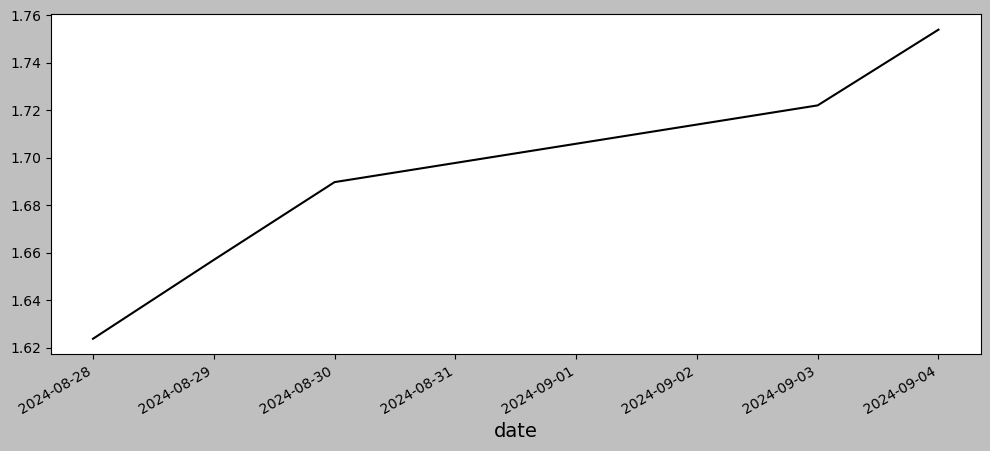

In [371]:
forecast = msft_forecast.variance
print(forecast)
pd.Series(forecast.values.ravel(), index=test.index).plot();

## There is more

In [374]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='Zero',
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)

In [376]:
results.params

omega       0.058609
alpha[1]    0.093495
beta[1]     0.891520
Name: params, dtype: float64

In [378]:
print(results.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -2415.74
Distribution:                  Normal   AIC:                           4837.48
Method:            Maximum Likelihood   BIC:                           4852.88
                                        No. Observations:                 1253
Date:                Wed, Jan 22 2025   Df Residuals:                     1253
Time:                        17:31:32   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0586  3.711e-02      1.579      0.114 [-1.41

In [380]:
msft_forecast = results.forecast(horizon=test.shape[0])
msft_forecast.mean[-1:]

h.1  h.2  h.3  h.4  h.5
date                               
2024-08-27  0.0  0.0  0.0  0.0  0.0

In [382]:
model = arch_model(train, 
                   p=1, q=1,
                   mean='LS', lags=1,
                   vol='GARCH',
                   dist='normal')
results = model.fit(disp=False)
results.params

Const       0.144878
omega       0.055152
alpha[1]    0.095416
beta[1]     0.891086
Name: params, dtype: float64

In [384]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Least Squares - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Least Squares   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2409.59
Distribution:                  Normal   AIC:                           4827.19
Method:            Maximum Likelihood   BIC:                           4847.72
                                        No. Observations:                 1253
Date:                Wed, Jan 22 2025   Df Residuals:                     1252
Time:                        17:31:35   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.1449  4.220e-02      3.433  5.973e-04 [6.216e-02,  0.228]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0552  3.504e-02      1.574      0.115 [-1.353e-02,  0.124]
alpha[1]       0.0954  2.516e-02      3.792  1.495e-04  [4.610e-02,  0.145]
beta[1]        0.8911  3.204e-02     27.809 3.350e-170    [  0.828,  0.954]
===========================================================================

Covariance estimator: robust
"""

In [386]:
results.model

Least Squares(constant: yes, lags: none, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x311f7b440

# Recipe 6: Automated Time Series Forecasting using Statsforecast

In [389]:
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, 
                                  AutoETS, 
                                  AutoTheta)
import matplotlib.pyplot as plt
from pathlib import Path

In [390]:
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y']
milk['unique_id'] = 'milk'

print(milk.head())
test_split = 12
train, test = split_data(milk, test_split)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')


          ds    y unique_id
0 1962-01-01  589      milk
1 1962-02-01  561      milk
2 1962-03-01  640      milk
3 1962-04-01  656      milk
4 1962-05-01  727      milk
train: 156 , test: 12
Train: (156, 3)
Test: (12, 3)


In [391]:
plt.style.use('grayscale')

plt.rc("figure", figsize=(16, 5))

In [395]:
sl = 12
models = [AutoARIMA(season_length=sl),
          AutoETS(season_length=sl),
          AutoTheta(season_length=sl)]


sf = StatsForecast(
    models = models,
    freq = 'MS'
)
sf.fit(train)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta])

In [396]:
# sf.fit(train,
#       id_col = 'unique_id',
#       time_col = 'month',
#       target_col = 'production')

**Forecast**
Memory Efficient predictions.

This method avoids memory burden due from object storage.
It is analogous to Scikit-Learn `fit_predict` without storing information.
It requires the forecast horizon `h` in advance.

**Predict**
Predict statistical models.

Use stored fitted `models` to predict large set of time series from DataFrame `df`.

In [398]:
n = test.shape[0]

forecast_df = sf.predict(h=n, level=[80,95])

In [399]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   unique_id        12 non-null     object        
 1   ds               12 non-null     datetime64[ns]
 2   AutoARIMA        12 non-null     float32       
 3   AutoARIMA-lo-95  12 non-null     float32       
 4   AutoARIMA-lo-80  12 non-null     float32       
 5   AutoARIMA-hi-80  12 non-null     float32       
 6   AutoARIMA-hi-95  12 non-null     float32       
 7   AutoETS          12 non-null     float32       
 8   AutoETS-lo-95    12 non-null     float32       
 9   AutoETS-lo-80    12 non-null     float32       
 10  AutoETS-hi-80    12 non-null     float32       
 11  AutoETS-hi-95    12 non-null     float32       
 12  AutoTheta        12 non-null     float32       
 13  AutoTheta-lo-80  12 non-null     float32       
 14  AutoTheta-hi-80  12 non-null     float32    

In [400]:
sf.fitted_

array([[AutoARIMA, AutoETS, AutoTheta]], dtype=object)

In [401]:
model_list = [str(models) for models in sf.models]
for i, m in enumerate(model_list):
    print(f'Model {i} = {m}  ')
    print(list(sf.fitted_[0][i].model_.keys()))

Model 0 = AutoARIMA  
['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'xreg', 'bic', 'aicc', 'ic', 'x', 'lambda']
Model 1 = AutoETS  
['loglik', 'aic', 'bic', 'aicc', 'mse', 'amse', 'fit', 'residuals', 'components', 'm', 'nstate', 'fitted', 'states', 'par', 'sigma2', 'n_params', 'method', 'actual_residuals']
Model 2 = AutoTheta  
['mse', 'amse', 'fit', 'residuals', 'm', 'states', 'par', 'n', 'modeltype', 'mean_y', 'decompose', 'decomposition_type', 'seas_forecast', 'fitted']


In [408]:
# AutoARIMA model 
sf.fitted_[0][0].model_.get('arma')

(2, 0, 0, 1, 12, 0, 1)

In [410]:
# AutoETS method
sf.fitted_[0][1].model_.get('method')

'ETS(A,A,A)'

In [412]:
# AutoTheta params
sf.fitted_[0][2].model_.get('par')

{'initial_smoothed': 301.76331057730624,
 'alpha': 0.9899999999999973,
 'theta': 10.539311991193415}

In [414]:
forecast_df = forecast_df.reset_index()

In [416]:
forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            12 non-null     int64         
 1   unique_id        12 non-null     object        
 2   ds               12 non-null     datetime64[ns]
 3   AutoARIMA        12 non-null     float32       
 4   AutoARIMA-lo-95  12 non-null     float32       
 5   AutoARIMA-lo-80  12 non-null     float32       
 6   AutoARIMA-hi-80  12 non-null     float32       
 7   AutoARIMA-hi-95  12 non-null     float32       
 8   AutoETS          12 non-null     float32       
 9   AutoETS-lo-95    12 non-null     float32       
 10  AutoETS-lo-80    12 non-null     float32       
 11  AutoETS-hi-80    12 non-null     float32       
 12  AutoETS-hi-95    12 non-null     float32       
 13  AutoTheta        12 non-null     float32       
 14  AutoTheta-lo-80  12 non-null     float32    

In [418]:
arima_cols = ['ds','AutoARIMA', 'AutoARIMA-lo-95', 'AutoARIMA-hi-95']
print(forecast_df[arima_cols].head())

          ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  840.524292       826.148376       854.900146
1 1975-02-01  797.604919       779.865784       815.343994
2 1975-03-01  904.082092       883.606018       924.558228
3 1975-04-01  919.784912       897.272827       942.297058
4 1975-05-01  984.401978       960.269409      1008.534607


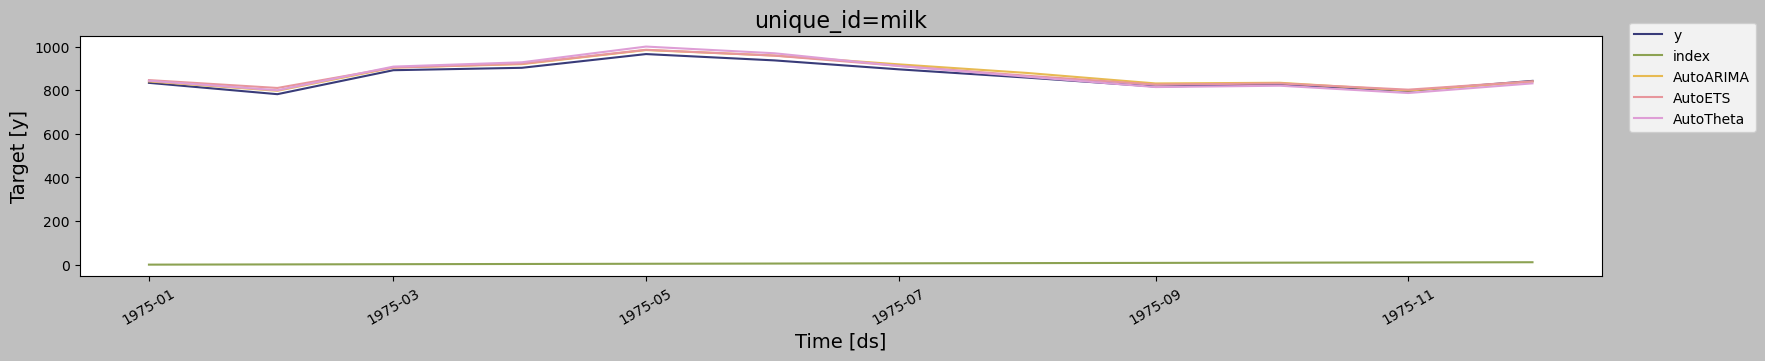

In [420]:
sf.plot(test, forecast_df)

In [422]:
sf.fitted_[0]

array([AutoARIMA, AutoETS, AutoTheta], dtype=object)

In [424]:
sf.fitted_[0,0].model_['arma']

(2, 0, 0, 1, 12, 0, 1)

In [426]:
sf.fitted_[0,2].model_['par']

{'initial_smoothed': 301.76331057730624,
 'alpha': 0.9899999999999973,
 'theta': 10.539311991193415}

In [428]:
sf.fitted_[0,1].model_['par']

array([ 3.72695678e-01,  4.55966814e-04,  4.90210842e-02,             nan,
        6.03907287e+02,  1.95409176e+00, -4.50990810e+01, -8.02254540e+01,
       -5.07111993e+01, -5.48733207e+01, -1.61115472e+01,  3.60823545e+01,
        8.40659294e+01,  1.14468617e+02,  5.13095161e+01,  3.42813569e+01,
       -5.50132584e+01, -1.81739133e+01])

AutoARIMA


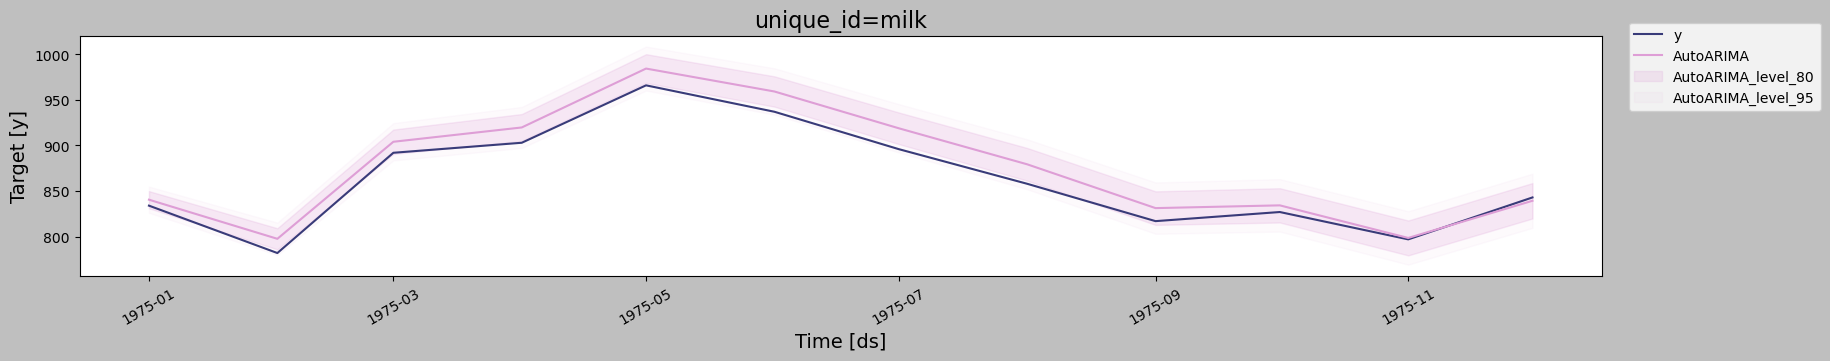

AutoETS


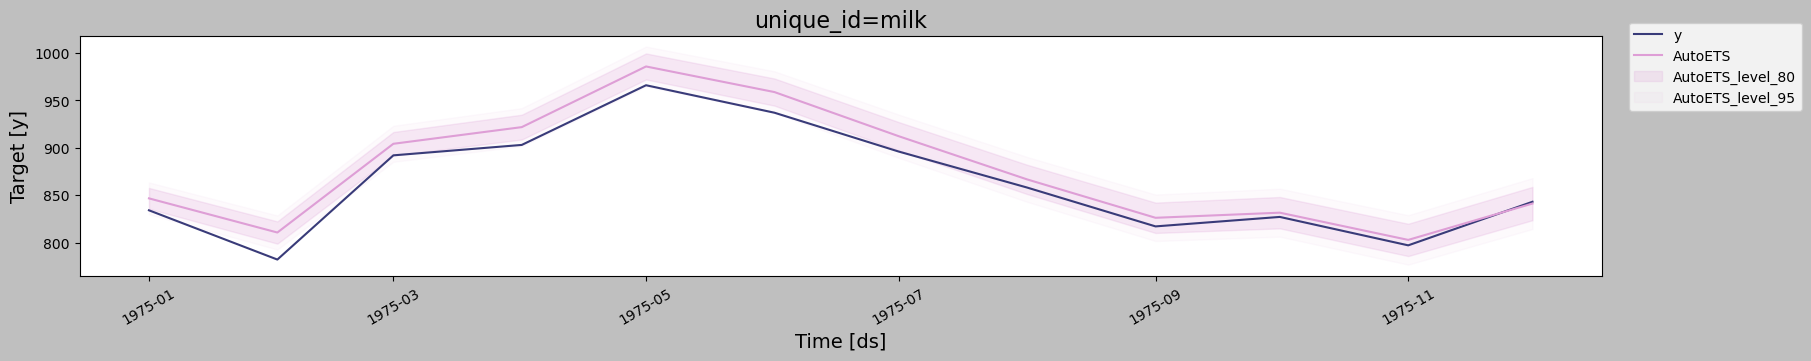

AutoTheta


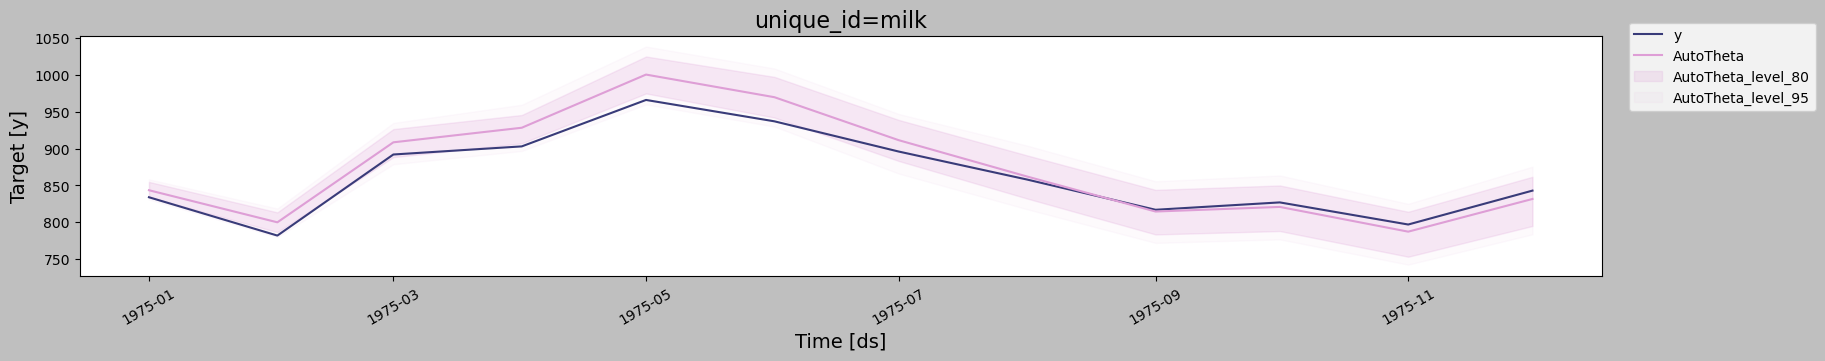

In [430]:
for model in sf.models:
    print(model)
    fig = sf.plot(test, forecast_df, models=[str(model)], level=[80,95])
    display(fig)

In [434]:
from utilsforecast.losses import mse, mape, rmse, mae
from utilsforecast.evaluation import evaluate

In [436]:
#final = test.merge(forecast_df, how='inner', on='ds')

In [438]:
metrics = [mae, mse, rmse, mape]

In [440]:
# h=12 forecast horizon is set to 12 months
# step_size = 12, each step size between each cross-validation window is 12 months. 
# n_window=1 only one-cross validation window is used 
crossvaldation_df = sf.cross_validation(
    df=milk,
    h=12,
    step_size=12,
    n_windows=4
)

In [441]:
sf.cross_validation(
    df=milk,
    h=12,
    step_size=12,
    n_windows=4
)

unique_id         ds     cutoff      y   AutoARIMA     AutoETS    AutoTheta
0       milk 1972-01-01 1971-12-01  826.0  835.644897  816.135010   833.166809
1       milk 1972-02-01 1971-12-01  799.0  792.584961  782.166321   789.943176
2       milk 1972-03-01 1971-12-01  890.0  891.021484  870.334045   897.904846
3       milk 1972-04-01 1971-12-01  900.0  909.428711  887.983398   919.605591
4       milk 1972-05-01 1971-12-01  961.0  972.341736  951.904297   993.479065
5       milk 1972-06-01 1971-12-01  935.0  944.871765  924.102783   961.981567
6       milk 1972-07-01 1971-12-01  894.0  900.721252  874.198608   900.446533
7       milk 1972-08-01 1971-12-01  855.0  863.671265  833.461365   848.833435
8       milk 1972-09-01 1971-12-01  809.0  821.674866  794.630493   802.520569
9       milk 1972-10-01 1971-12-01  810.0  828.426331  801.355225   808.708557
10      milk 1972-11-01 1971-12-01  766.0  794.366455  774.464294   777.214966
11      milk 1972-12-01 1971-12-01  805.0  832.953369  811.552307   822.302979
12      milk 1973-01-01 1972-12-01  821.0  836.856384  841.309326   837.120667
13      milk 1973-02-01 1972-12-01  773.0  801.292236  809.675110   795.259888
14      milk 1973-03-01 1972-12-01  883.0  897.255981  897.731018   902.096008
15      milk 1973-04-01 1972-12-01  898.0  913.246033  916.106384   922.770264
16      milk 1973-05-01 1972-12-01  957.0  975.994324  978.437683   995.868530
17      milk 1973-06-01 1972-12-01  924.0  949.769348  952.204529   964.882080
18      milk 1973-07-01 1972-12-01  881.0  907.011536  900.550964   904.699524
19      milk 1973-08-01 1972-12-01  837.0  869.415710  859.144897   854.260132
20      milk 1973-09-01 1972-12-01  784.0  826.481140  821.346436   807.658386
21      milk 1973-10-01 1972-12-01  791.0  831.224121  826.530945   814.228149
22      milk 1973-11-01 1972-12-01  760.0  794.069824  799.401306   781.895325
23      milk 1973-12-01 1972-12-01  802.0  833.052856  835.286621   826.482361
24      milk 1974-01-01 1973-12-01  828.0  828.809631  830.610657   832.578369
25      milk 1974-02-01 1973-12-01  778.0  789.962524  793.599792   790.410950
26      milk 1974-03-01 1973-12-01  889.0  892.149597  890.715210   897.326294
27      milk 1974-04-01 1973-12-01  902.0  909.006836  904.547668   917.583252
28      milk 1974-05-01 1973-12-01  969.0  971.457947  969.684753   989.250610
29      milk 1974-06-01 1973-12-01  947.0  943.792908  942.531067   958.202759
30      milk 1974-07-01 1973-12-01  908.0  901.772888  894.393311   899.908997
31      milk 1974-08-01 1973-12-01  867.0  862.697754  850.088257   850.853638
32      milk 1974-09-01 1973-12-01  815.0  817.044678  812.249390   804.619141
33      milk 1974-10-01 1973-12-01  812.0  823.422363  816.546631   810.681580
34      milk 1974-11-01 1973-12-01  773.0  789.466125  786.564514   777.411438
35      milk 1974-12-01 1973-12-01  813.0  830.225830  825.265747   821.361877
36      milk 1975-01-01 1974-12-01  834.0  840.524292  846.591675   843.520935
37      milk 1975-02-01 1974-12-01  782.0  797.604919  810.539246   799.982239
38      milk 1975-03-01 1974-12-01  892.0  904.082092  904.197937   908.517029
39      milk 1975-04-01 1974-12-01  903.0  919.784912  921.789368   928.294250
40      milk 1975-05-01 1974-12-01  966.0  984.401978  985.821167  1000.434998
41      milk 1975-06-01 1974-12-01  937.0  959.240173  958.794495   969.719666
42      milk 1975-07-01 1974-12-01  896.0  918.909119  912.204163   911.412842
43      milk 1975-08-01 1974-12-01  858.0  879.371277  866.595459   862.094849
44      milk 1975-09-01 1974-12-01  817.0  831.288025  826.084106   814.616882
45      milk 1975-10-01 1974-12-01  827.0  834.313416  831.479309   820.871521
46      milk 1975-11-01 1974-12-01  797.0  798.555603  802.735352   787.312134
47      milk 1975-12-01 1974-12-01  843.0  839.351746  841.116089   831.675293

In [442]:
print(crossvaldation_df.head())

  unique_id         ds     cutoff      y   AutoARIMA     AutoETS   AutoTheta
0      milk 1972-01-01 1971-12-01  826.0  835.644897  816.135010  833.166809
1      milk 1972-02-01 1971-12-01  799.0  792.584961  782.166321  789.943176
2      milk 1972-03-01 1971-12-01  890.0  891.021484  870.334045  897.904846
3      milk 1972-04-01 1971-12-01  900.0  909.428711  887.983398  919.605591
4      milk 1972-05-01 1971-12-01  961.0  972.341736  951.904297  993.479065


In [443]:
crossvaldation_df.shape

(48, 7)

In [448]:
print(crossvaldation_df[['ds', 'cutoff', 'y', 'AutoARIMA']])

           ds     cutoff      y   AutoARIMA
0  1972-01-01 1971-12-01  826.0  835.644897
1  1972-02-01 1971-12-01  799.0  792.584961
2  1972-03-01 1971-12-01  890.0  891.021484
3  1972-04-01 1971-12-01  900.0  909.428711
4  1972-05-01 1971-12-01  961.0  972.341736
5  1972-06-01 1971-12-01  935.0  944.871765
6  1972-07-01 1971-12-01  894.0  900.721252
7  1972-08-01 1971-12-01  855.0  863.671265
8  1972-09-01 1971-12-01  809.0  821.674866
9  1972-10-01 1971-12-01  810.0  828.426331
10 1972-11-01 1971-12-01  766.0  794.366455
11 1972-12-01 1971-12-01  805.0  832.953369
12 1973-01-01 1972-12-01  821.0  836.856384
13 1973-02-01 1972-12-01  773.0  801.292236
14 1973-03-01 1972-12-01  883.0  897.255981
15 1973-04-01 1972-12-01  898.0  913.246033
16 1973-05-01 1972-12-01  957.0  975.994324
17 1973-06-01 1972-12-01  924.0  949.769348
18 1973-07-01 1972-12-01  881.0  907.011536
19 1973-08-01 1972-12-01  837.0  869.415710
20 1973-09-01 1972-12-01  784.0  826.481140
21 1973-10-01 1972-12-01  791.0 

In [450]:
evaluation = evaluate(
    crossvaldation_df.reset_index(),
    metrics=metrics,
    models=model_list,
    # level=[80, 95]
)
print(evaluation.drop(columns='unique_id'))

  metric   AutoARIMA     AutoETS   AutoTheta
0    mae   15.087765   15.322071   15.726689
1    mse  338.023010  334.270325  344.069336
2   rmse   18.385403   18.283062   18.549107
3   mape    0.018029    0.018218    0.018136


In [452]:
evaluation['Best_Model'] = evaluation[['AutoARIMA', 
                                       'AutoETS', 
                                       'AutoTheta']].idxmin(axis=1)
print(evaluation)

  unique_id metric   AutoARIMA     AutoETS   AutoTheta Best_Model
0      milk    mae   15.087765   15.322071   15.726689  AutoARIMA
1      milk    mse  338.023010  334.270325  344.069336    AutoETS
2      milk   rmse   18.385403   18.283062   18.549107    AutoETS
3      milk   mape    0.018029    0.018218    0.018136  AutoARIMA


In [454]:
sf.fitted_[0][0].model_.get('arma')

(2, 0, 0, 1, 12, 0, 1)

In [456]:
test.shape

(12, 3)

In [458]:
train.shape

(156, 3)

In [460]:
milk['ds'].dt.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975], dtype=int32)

## There is more

In [463]:
milk_file = Path('../../datasets/Ch11/cpi.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'])
milk.columns = ['ds', 'y', 'X']
milk['unique_id'] = 'milk'

In [465]:
print(milk.head())

          ds    y      X unique_id
0 1962-01-01  589  30.04      milk
1 1962-02-01  561  30.11      milk
2 1962-03-01  640  30.17      milk
3 1962-04-01  656  30.21      milk
4 1962-05-01  727  30.24      milk


In [467]:
train, test = split_data(milk, 12)

train: 156 , test: 12


In [469]:
train

ds    y      X unique_id
0   1962-01-01  589  30.04      milk
1   1962-02-01  561  30.11      milk
2   1962-03-01  640  30.17      milk
3   1962-04-01  656  30.21      milk
4   1962-05-01  727  30.24      milk
..         ...  ...    ...       ...
151 1974-08-01  867  49.90      milk
152 1974-09-01  815  50.60      milk
153 1974-10-01  812  51.00      milk
154 1974-11-01  773  51.50      milk
155 1974-12-01  813  51.90      milk

[156 rows x 4 columns]

In [471]:
X_test = test.drop(columns=['y'])
X_test

ds     X unique_id
156 1975-01-01  52.3      milk
157 1975-02-01  52.6      milk
158 1975-03-01  52.8      milk
159 1975-04-01  53.0      milk
160 1975-05-01  53.1      milk
161 1975-06-01  53.5      milk
162 1975-07-01  54.0      milk
163 1975-08-01  54.2      milk
164 1975-09-01  54.6      milk
165 1975-10-01  54.9      milk
166 1975-11-01  55.3      milk
167 1975-12-01  55.6      milk

In [473]:
Y_test = test.drop(columns=['X'])
Y_test

ds    y unique_id
156 1975-01-01  834      milk
157 1975-02-01  782      milk
158 1975-03-01  892      milk
159 1975-04-01  903      milk
160 1975-05-01  966      milk
161 1975-06-01  937      milk
162 1975-07-01  896      milk
163 1975-08-01  858      milk
164 1975-09-01  817      milk
165 1975-10-01  827      milk
166 1975-11-01  797      milk
167 1975-12-01  843      milk

In [475]:
models = [AutoARIMA(season_length = 12)]
sf = StatsForecast(
    models=models, 
    freq='MS', 
    n_jobs=-1
)
# sf.fit(train)

In [477]:
train

ds    y      X unique_id
0   1962-01-01  589  30.04      milk
1   1962-02-01  561  30.11      milk
2   1962-03-01  640  30.17      milk
3   1962-04-01  656  30.21      milk
4   1962-05-01  727  30.24      milk
..         ...  ...    ...       ...
151 1974-08-01  867  49.90      milk
152 1974-09-01  815  50.60      milk
153 1974-10-01  812  51.00      milk
154 1974-11-01  773  51.50      milk
155 1974-12-01  813  51.90      milk

[156 rows x 4 columns]

In [479]:
forecast = sf.forecast(df=train, X_df=X_test, h=12, level=[95])
print(forecast.reset_index())

    index unique_id         ds   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0       0      milk 1975-01-01  838.484076       823.918138       853.050014
1       1      milk 1975-02-01  794.040722       775.835352       812.246092
2       2      milk 1975-03-01  899.036193       877.806391       920.265994
3       3      milk 1975-04-01  913.368434       889.494318       937.242550
4       4      milk 1975-05-01  976.887275       950.633849      1003.140701
5       5      milk 1975-06-01  950.321504       921.887170       978.755838
6       6      milk 1975-07-01  908.351408       877.891922       938.810894
7       7      milk 1975-08-01  868.115873       835.757732       900.474013
8       8      milk 1975-09-01  819.073143       784.921742       853.224545
9       9      milk 1975-10-01  821.212301       785.357216       857.067387
10     10      milk 1975-11-01  784.536764       747.055353       822.018174
11     11      milk 1975-12-01  824.538704       785.498659       863.578748

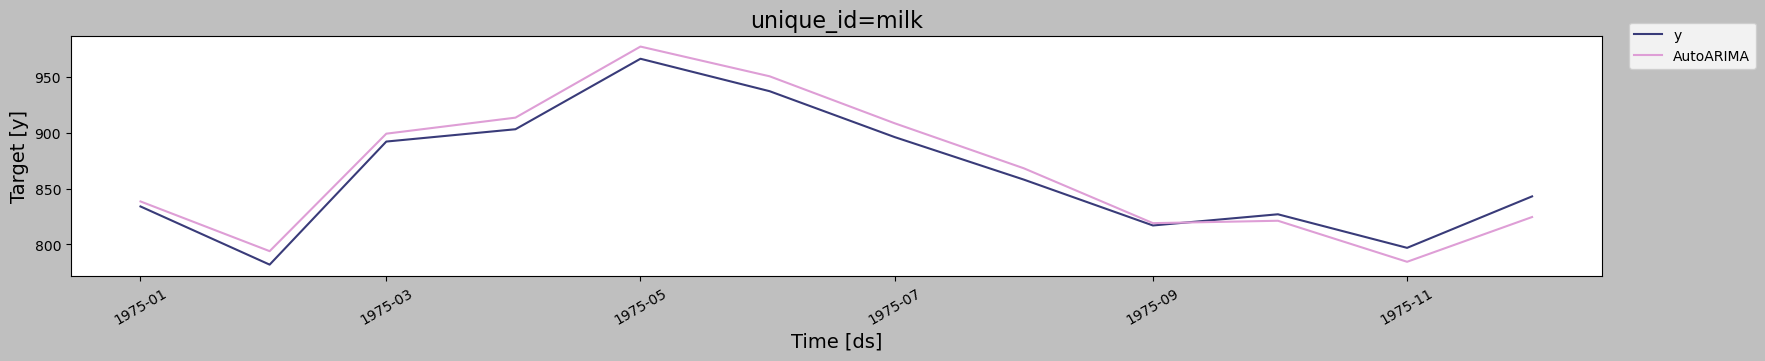

In [480]:
sf.plot(test, forecast)

In [483]:
res = Y_test.merge(forecast, how='left', on=['unique_id', 'ds'])
print(res.head())

          ds    y unique_id   AutoARIMA  AutoARIMA-lo-95  AutoARIMA-hi-95
0 1975-01-01  834      milk  838.484076       823.918138       853.050014
1 1975-02-01  782      milk  794.040722       775.835352       812.246092
2 1975-03-01  892      milk  899.036193       877.806391       920.265994
3 1975-04-01  903      milk  913.368434       889.494318       937.242550
4 1975-05-01  966      milk  976.887275       950.633849      1003.140701


In [485]:
mae = abs(res['y']-res['AutoARIMA']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 9.95


In [487]:
# model without exogenous variables (univariate)
forecast_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=12)

res_u = Y_test.merge(forecast_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoARIMA']).mean()

In [488]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))


The MAE without exogenous regressors is 13.56


# Extra: Auto Time Series Analysis with PyCaret

In [1]:
import pycaret

In [2]:
pycaret.__version__

'3.3.2'

In [3]:
from pycaret.time_series import *
from pycaret.datasets import get_data

In [4]:
from pathlib import Path
import pandas as pd
milk_file = Path('../../datasets/Ch11/milk_production.csv')
milk = pd.read_csv(milk_file, parse_dates=['month'], index_col='month')
milk.head()

production
month                 
1962-01-01         589
1962-02-01         561
1962-03-01         640
1962-04-01         656
1962-05-01         727

In [5]:
s = setup(milk, fh=12, session_id=123)

In [6]:
best = compare_models()

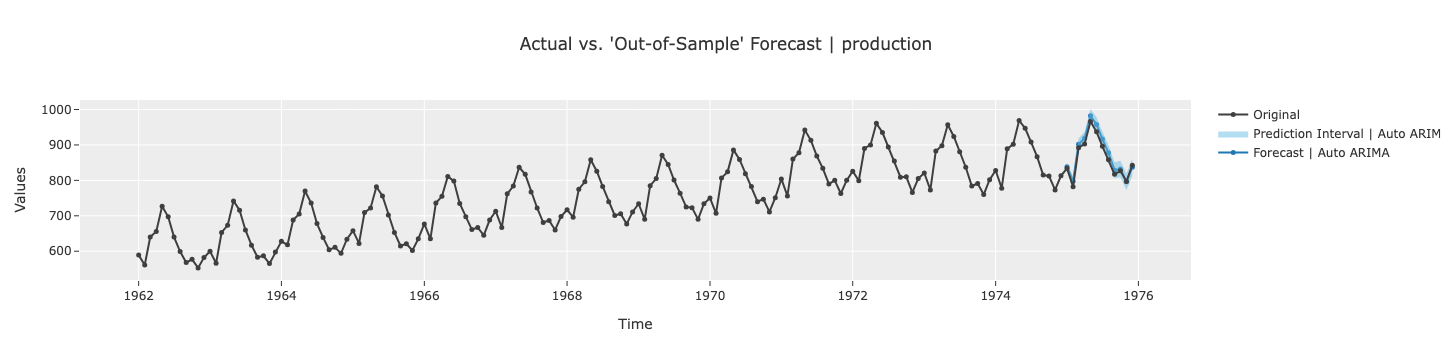

In [7]:
plot_model(best)

In [8]:
best

AutoARIMA(random_state=123, sp=12, suppress_warnings=True)

In [9]:
pred_holdout = predict_model(best)

In [10]:
pred_holdout

y_pred
1975-01  838.7895
1975-02  797.3099
1975-03  902.0014
1975-04  918.9837
1975-05  982.1626
1975-06  957.9743
1975-07  916.6131
1975-08  877.7434
1975-09  828.8068
1975-10  832.2789
1975-11  795.9177
1975-12  837.0735

In [22]:
print(best.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(3, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -490.431
Date:                            Sat, 12 Oct 2024   AIC                            994.862
Time:                                    16:48:18   BIC                           1015.650
Sample:                                01-31-1962   HQIC                          1003.309
                                     - 12-31-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.3092      2.038      1.623      0.105      -0.686       7.304
ar.L1         -0.2335      0.096   